In [1]:
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.ensemble import RandomForestRegressor

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

/anaconda3/envs/neuro/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Data Preparation

In [6]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [7]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

In [8]:
# Reset scaling and transformation
temp = scaler_targets.inverse_transform(targets)
temp[:, 1:] = np.power(temp[:, 1:], 1./1.5)
df_target = pd.DataFrame(temp, columns=targets.columns)
df_target.head()

age  domain1_var1  domain1_var2  domain2_var1  domain2_var2
0  57.436077     30.571975     62.553736     53.325130     51.427998
1  59.580851     50.969456     67.470628     60.651856     58.311361
2  71.413018     53.152498     58.012103     52.418389     62.536641
3  66.532630           NaN           NaN     52.108977     69.993075
4  38.617381     49.197021     65.674285     40.151376     34.096421

In [9]:
filenames = sorted(glob('results/results_tr*csv'))
labels = np.array([[r[19:].split('_')[0], '_'.join(r[19:].split('.')[0].split('_')[1:])[:'_'.join(r[19:].split('.')[0].split('_')[1:]).find('merge')+5]] for r in filenames])
labels

array([['baseline', 'merge'],
       ['nn-multi', 'merge'],
       ['nn-multi', 'short_merge'],
       ['nn-single', 'merge'],
       ['nn-single', 'short_merge'],
       ['ridge', 'age_merge'],
       ['ridge', 'age_short_merge'],
       ['ridge', 'merge'],
       ['ridge', 'short_merge'],
       ['sgd', 'age_merge'],
       ['sgd', 'age_short_merge'],
       ['sgd', 'merge'],
       ['sgd', 'short_merge'],
       ['svr-linear', 'age_merge'],
       ['svr-linear', 'age_short_merge'],
       ['svr-linear', 'merge'],
       ['svr-linear', 'short_merge'],
       ['svr-rbf', 'age_merge'],
       ['svr-rbf', 'age_short_merge'],
       ['svr-rbf', 'merge'],
       ['svr-rbf', 'short_merge']], dtype='<U15')

In [10]:
# Collect datasets
dataset = []
for i, f in enumerate(filenames):
    df_temp = pd.read_csv(f)
    df_temp['model'] = labels[i, 0]
    df_temp['dataset'] = labels[i, 1]
    dataset.append(df_temp)
df_data = pd.concat(dataset)

### Combine all predictions into one dataset

In [11]:
def get_data(tid = '_te'):
    filenames = sorted(glob('results/results%s*csv' % tid))
    labels = np.array([[r[19:].split('_')[0], '_'.join(r[19:].split('.')[0].split('_')[1:])[:'_'.join(r[19:].split('.')[0].split('_')[1:]).find('merge')+5]] for r in filenames])
    labels

    for i, f in enumerate(filenames):
        m, d = labels[i]

        df_temp = pd.read_csv(f)
        df_temp = df_temp.set_index('Id')
        df_temp.columns = ['%s_%s-%s' % (c, m, d) for c in df_temp.columns]

        if i ==0:
            df_res = df_temp.copy()
        else:
            df_res = pd.merge(df_res, df_temp, on='Id')

    return df_res.T.drop_duplicates().T

In [12]:
def load_dataset():

    # Load dataset
    X_tr = get_data(tid = '_tr')
    X_te = get_data(tid = '_te')

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y_tr = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')

    # Remove missing values
    idx = y_tr.index.isin(X_tr.index)
    y_tr = y_tr[idx].values

    # Reset scaling and transformation
    y_tr = scaler_targets.inverse_transform(y_tr)
    y_tr[:, 1:] = np.power(y_tr[:, 1:], 1./1.5)

    return X_tr, X_te, y_tr, idx

In [13]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0) / np.sum(y_true, axis=0))

In [14]:
def create_grid(model_metric, estimator=None, cv=5, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    n_trees = [20, 50, 100, 200]
    param_grid = [
    { 
        'scaler': [RobustScaler(),
                   PowerTransformer()
                   ],
        'pca': [None],
        'estimator__n_estimators': n_trees,
        'estimator__max_depth': [10, 20, 50, None],
        'estimator__min_samples_leaf': [2, 4, 8],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [15]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    """
    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]
    """
    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [16]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [17]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__n_estimators'].astype('int')
    df_pred['param_estimator__max_depth'] = df_pred['param_estimator__max_depth'].astype('str')
    df_pred['param_estimator__min_samples_leaf'] = df_pred['param_estimator__min_samples_leaf'].astype('int')
    
    return df_pred

In [18]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for m in df_pred['param_estimator__max_depth'].unique():
                for s2 in df_pred['param_estimator__min_samples_leaf'].unique():

                        df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                                   df_pred['param_scaler']==s,
                                                   df_pred['param_estimator__max_depth']==m,
                                                   df_pred['param_estimator__min_samples_leaf']==s2,
                                                  ],
                                                  axis=0).astype('bool')]
                        df_plot = df_plot.sort_values('param_estimator__alpha')

                        # Skip hyperparameter combination if not explored
                        if df_plot.shape[0] == 0:
                            continue

                        # Extract relevant modelling metrics
                        train_scores = df_plot['mean_train_score']
                        valid_scores = df_plot['mean_test_score']
                        std_tr = df_plot['std_train_score']
                        std_va = df_plot['std_test_score']

                        plt.figure(figsize=(12, 4))
                        alphas = df_plot['param_estimator__alpha']
                        plt.plot(alphas, train_scores, label='Training Set')
                        plt.plot(alphas, valid_scores, label='Validation Set')

                        # Add marker and text for best score
                        max_id = np.argmax(valid_scores)
                        x_pos = alphas.iloc[max_id]
                        y_pos = valid_scores.iloc[max_id]
                        txt = '{:0.4f}'.format(y_pos)
                        plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                        plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                        # Quantify variance with ±std curves
                        plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                        plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                        plt.ylabel('Performance metric')
                        plt.xlabel('Model parameter')

                        # Adjust x-lim, y-lim, add legend and adjust layout
                        plt.legend()
                        plt.title('%s\n%s\n%s\n%s' % (str(s), str(p), str(m), str(s2)))
                        plt.show()

In [19]:
def run_prediction(model_metric, target='age', estimator=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset()
    y_tr = y_tr[:, tidx]
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [20]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:10])

In [21]:
def create_results_dataframe(predictions, targets, t_idx, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Store results in Dataframe
    df_results = pd.DataFrame(results, columns=targets.columns)

    """
    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]
    """

    # Add ID back to test results
    if res_type=='_tr':
        df_results.insert(0, 'Id', t_idx[predictions['age_miss']])
        df_results.set_index('Id', inplace=True)
    elif res_type=='_te':
        df_results.insert(0, 'Id', t_idx)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [22]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [23]:
def save_results(predictions, targets, train_id, test_id, sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, targets, train_id, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, targets, test_id, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/h_submission_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/h_results_tr_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/h_results_te_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [24]:
def plot_prediction_distributions(targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(targets, columns=targets.columns)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

Starting with target: age
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 21.6min finished


Best: -0.035672 using {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 200, 'pca': None, 'scaler': RobustScaler()}


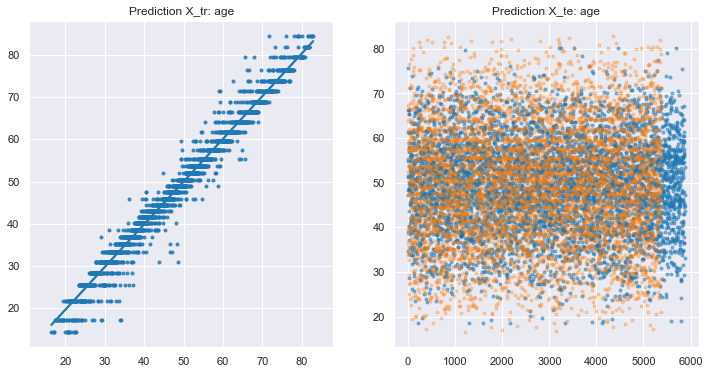

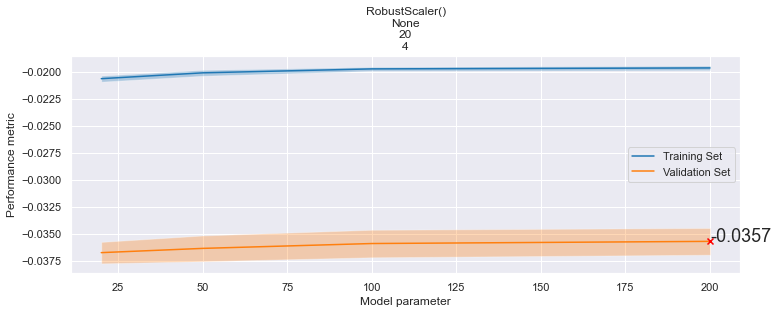

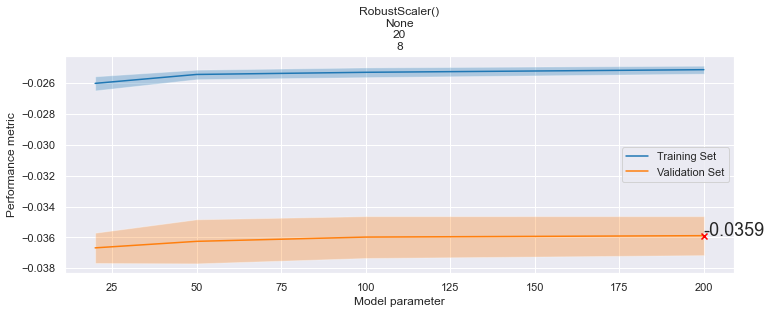

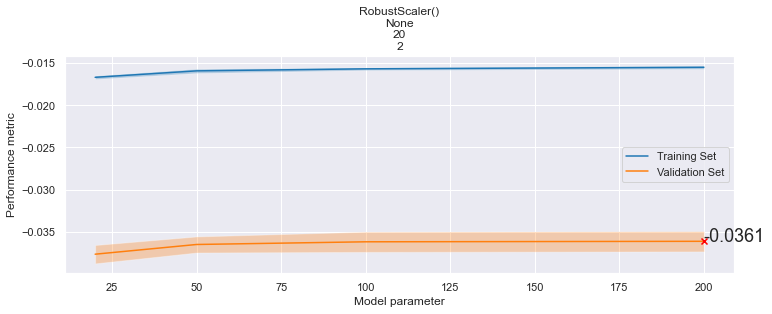

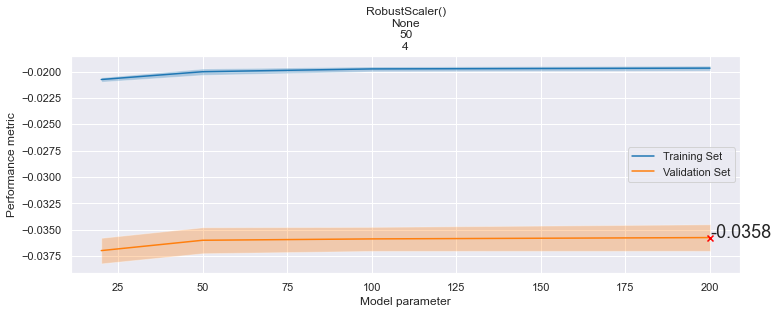

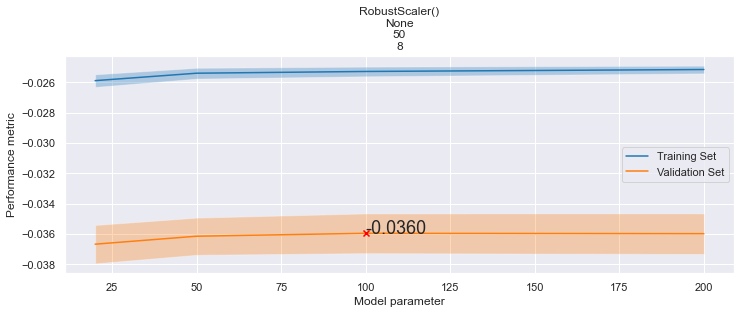

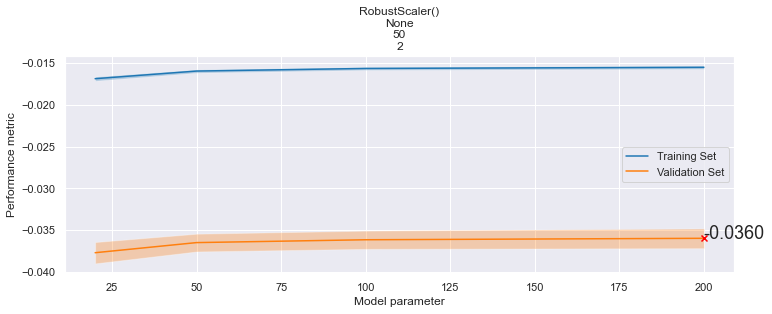

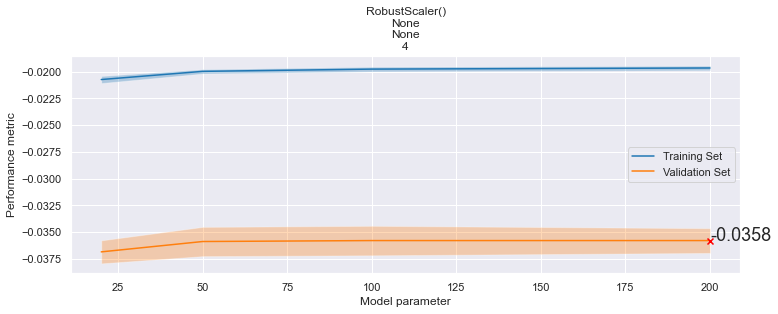

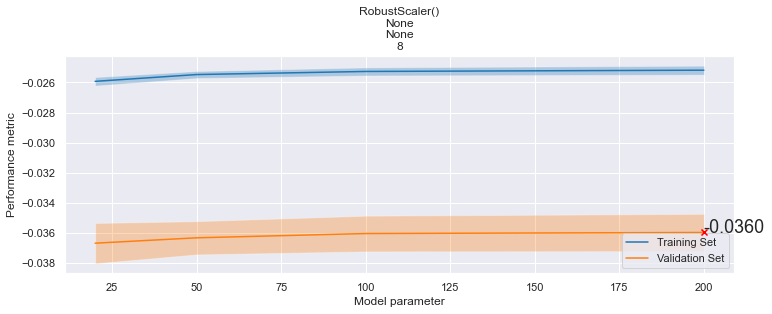

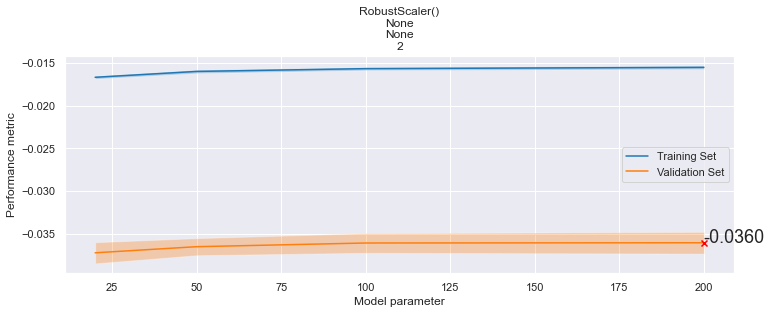

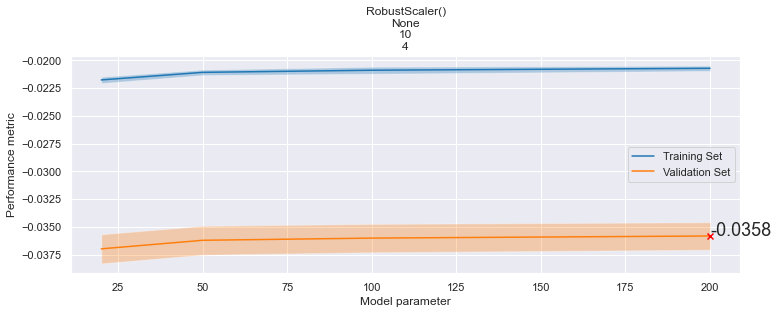

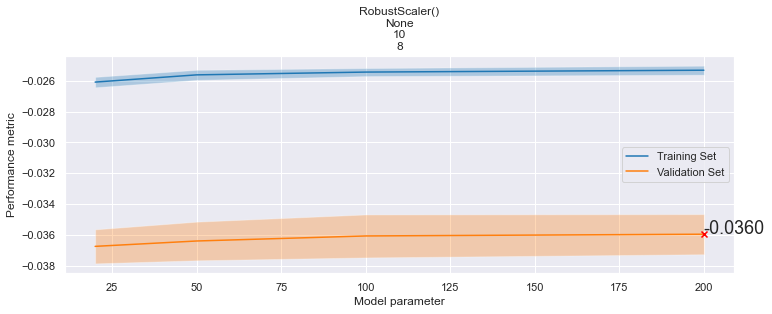

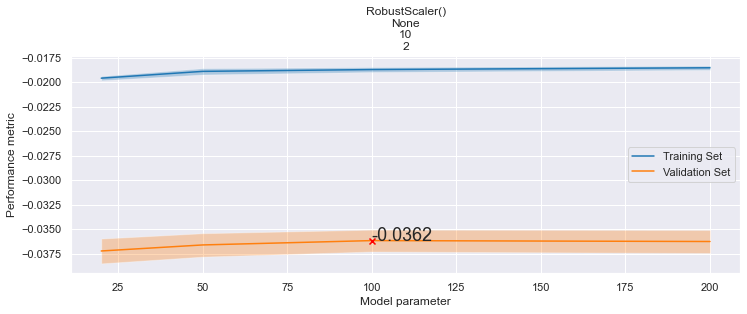

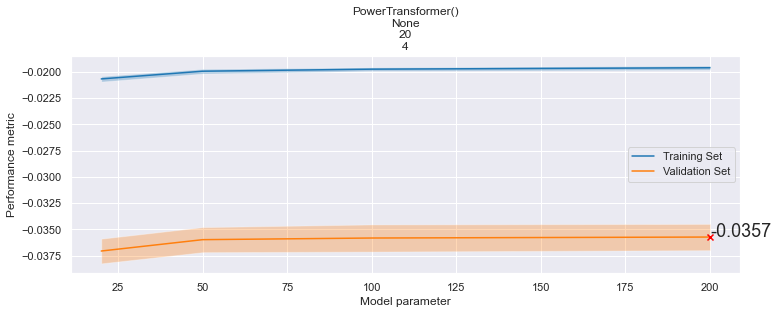

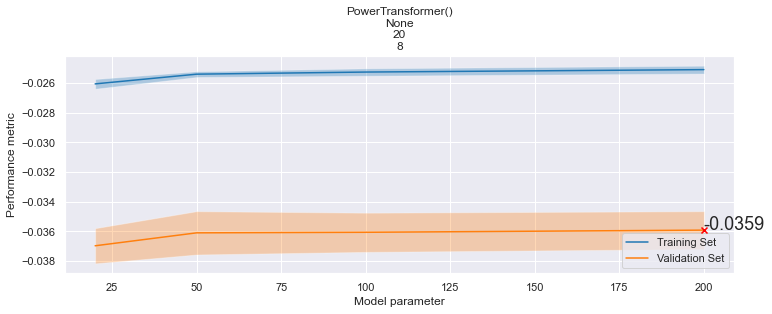

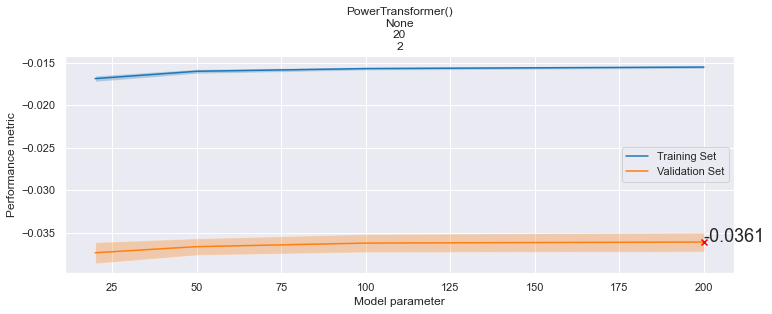

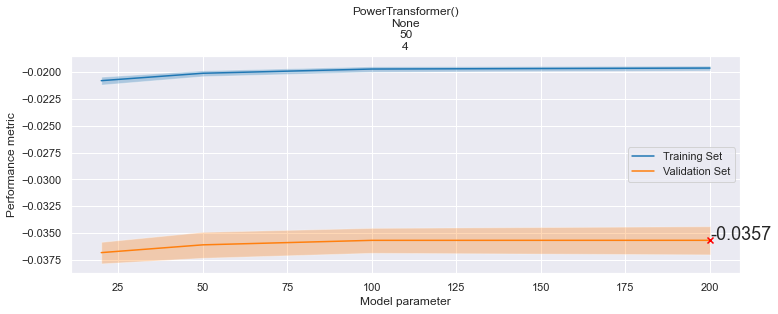

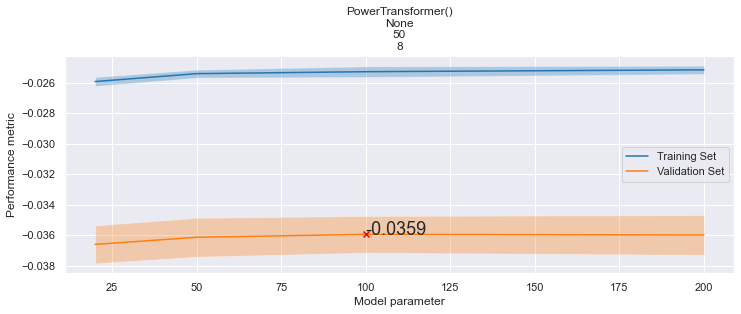

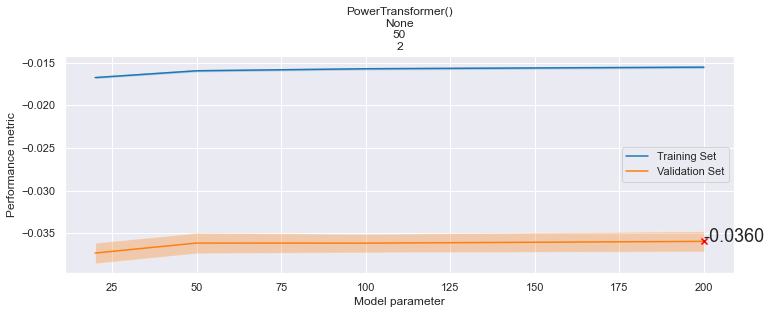

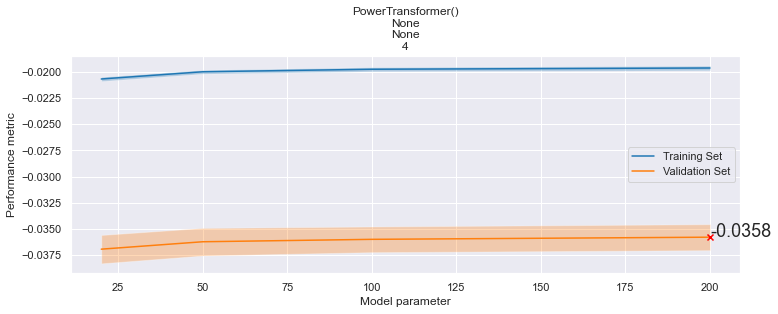

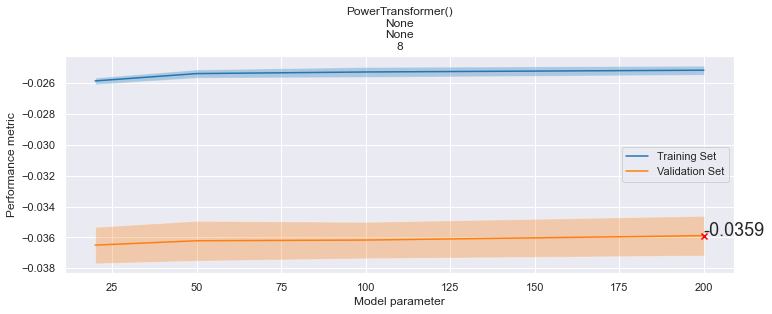

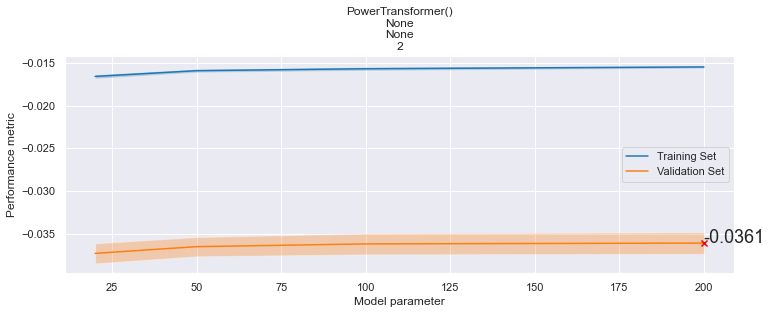

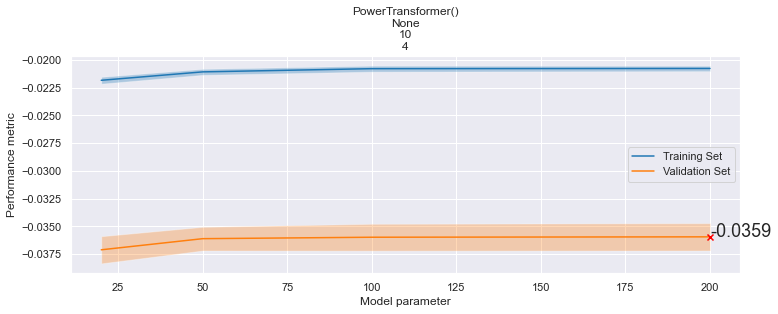

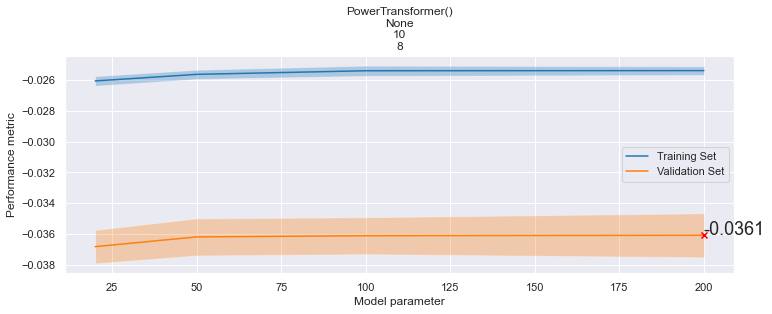

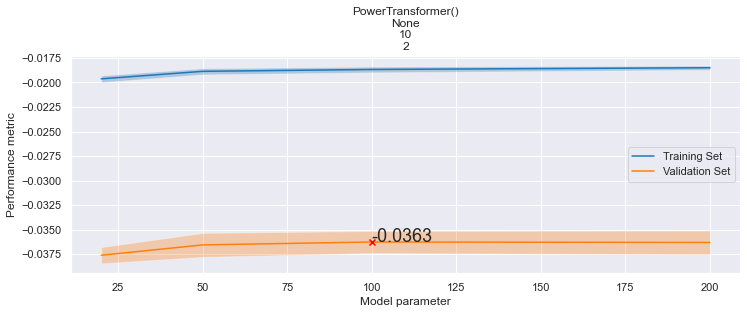

param_estimator__max_depth param_estimator__min_samples_leaf  \
38                         20                                 4   
63                         50                                 4   
61                         50                                 4   
39                         20                                 4   
62                         50                                 4   
86                       None                                 4   
84                       None                                 4   
87                       None                                 4   
14                         10                                 4   
37                         20                                 4   

   param_estimator__n_estimators param_pca        param_scaler  \
38                           200      None      RobustScaler()   
63                           200      None  PowerTransformer()   
61                           100      None  PowerTransformer()   
39                           200      None  PowerTransformer()   
62                           200      None      RobustScaler()   
86                           200      None      RobustScaler()   
84                           100      None      RobustScaler()   
87                           200      None  PowerTransformer()   
14                           200      None      RobustScaler()   
37                           100      None  PowerTransformer()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
38        -0.035672        0.001233         -0.019662         0.000207  
63        -0.035680        0.001313         -0.019606         0.000221  
61        -0.035683        0.001161         -0.019696         0.000253  
39        -0.035721        0.001248         -0.019612         0.000196  
62        -0.035752        0.001257         -0.019673         0.000230  
86        -0.035778        0.001154         -0.019661         0.000214  
84        -0.035778        0.001376         -0.019766         0.000220  
87        -0.035787        0.001240         -0.019631         0.000220  
14        -0.035808        0.001235         -0.020721         0.000234  
37        -0.035813        0.001291         -0.019746         0.000172

Starting with target: domain1_var1
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 23.5min finished


Best: -0.052539 using {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 8, 'estimator__n_estimators': 200, 'pca': None, 'scaler': RobustScaler()}


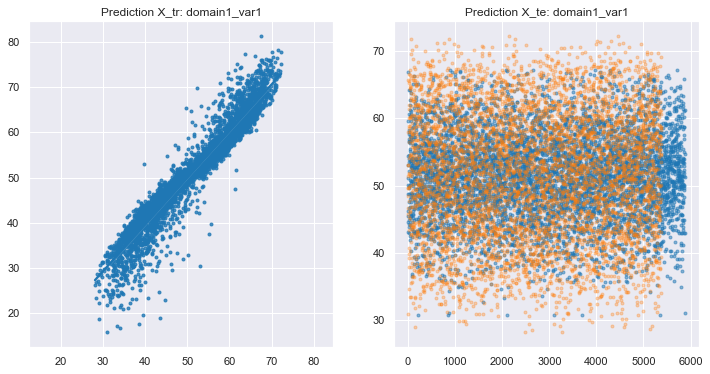

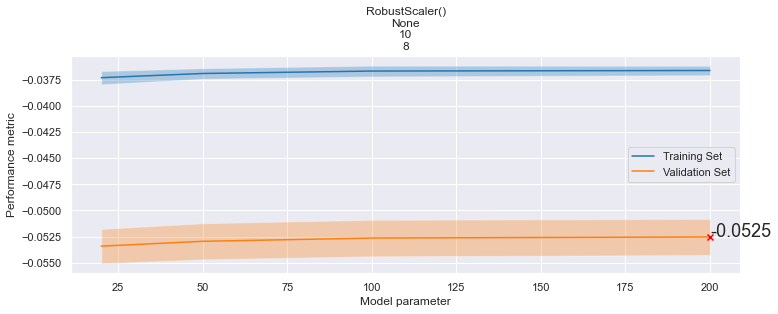

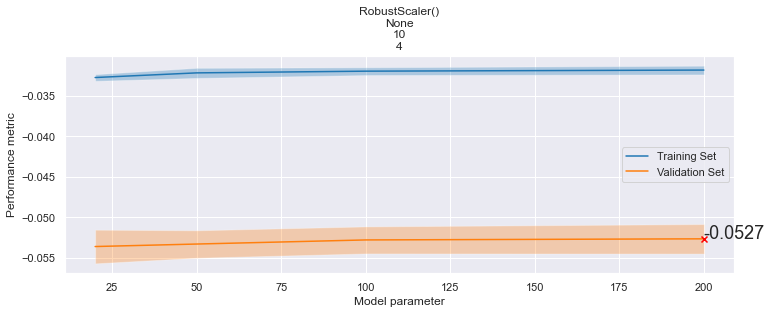

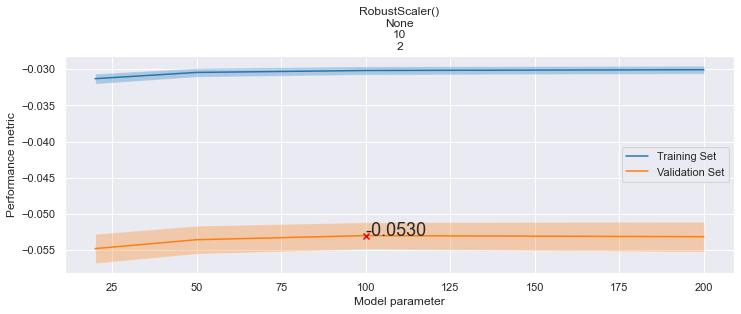

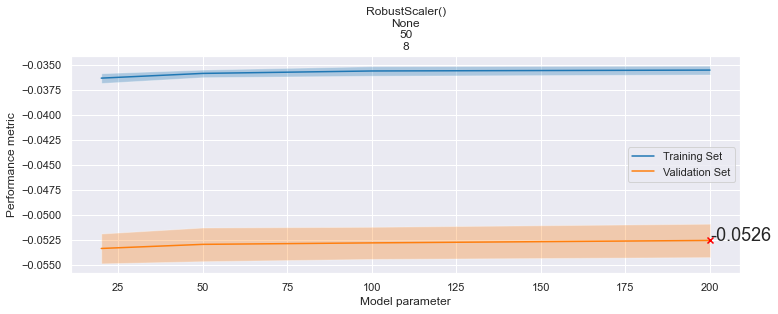

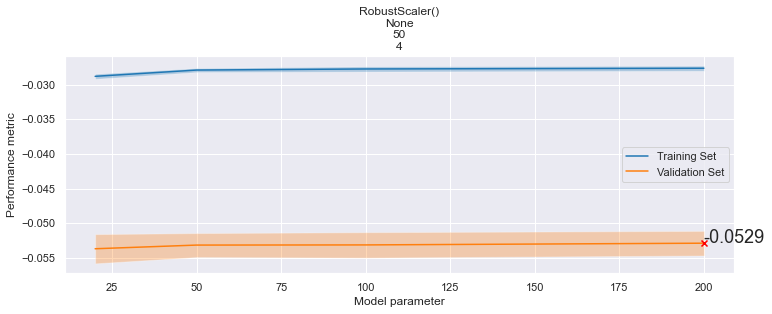

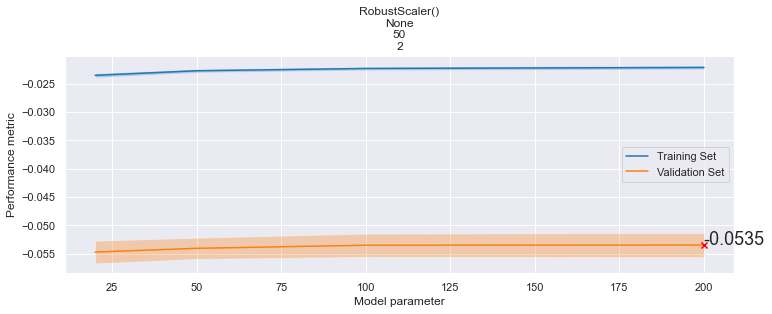

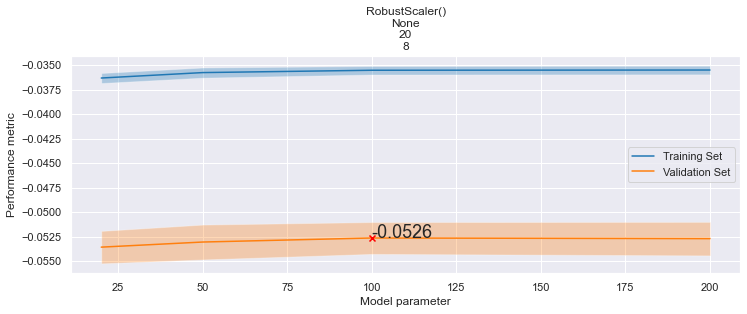

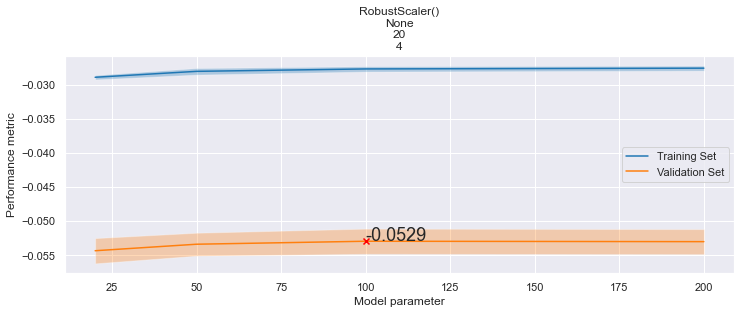

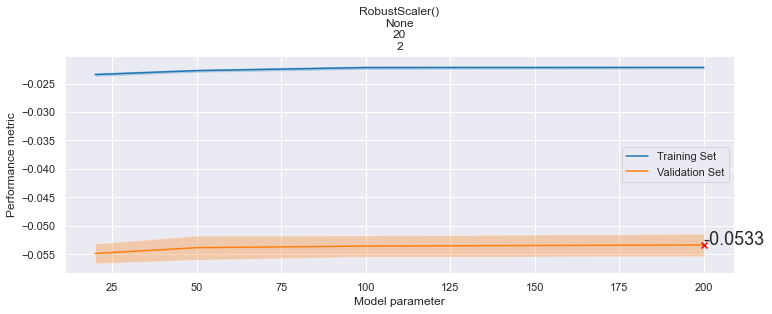

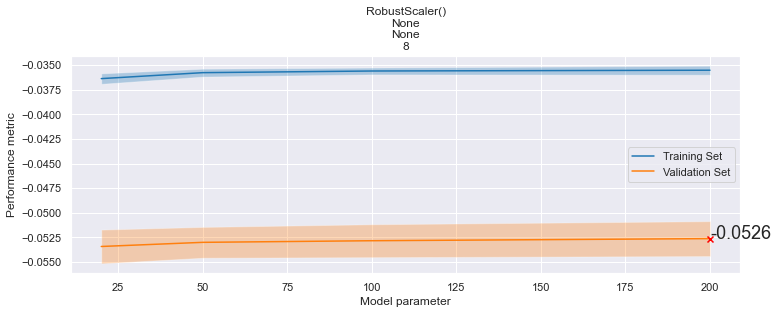

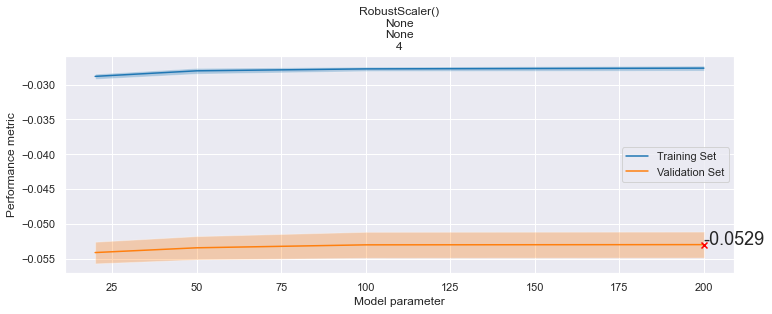

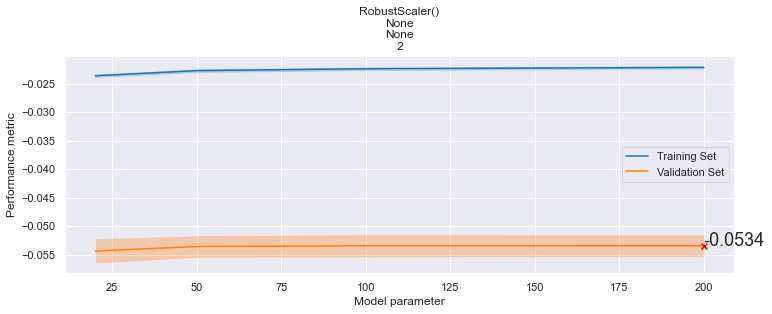

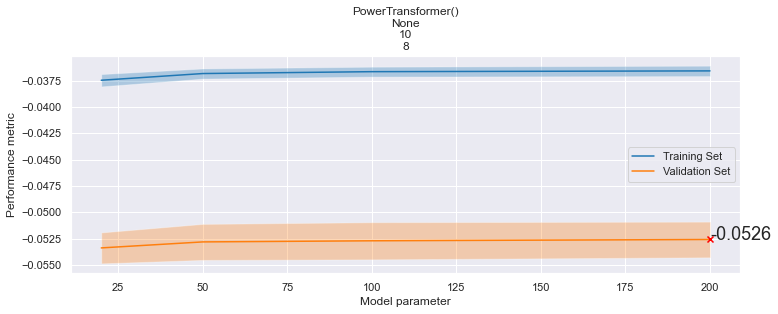

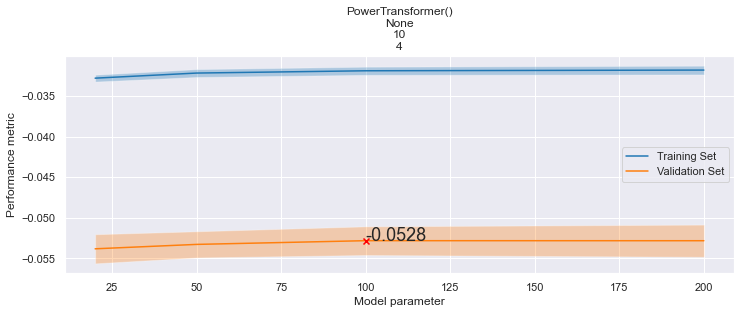

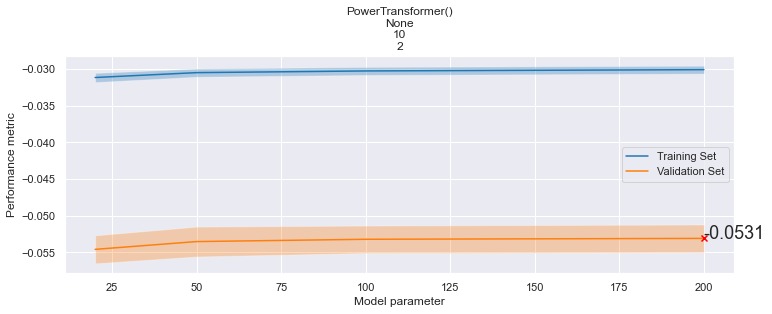

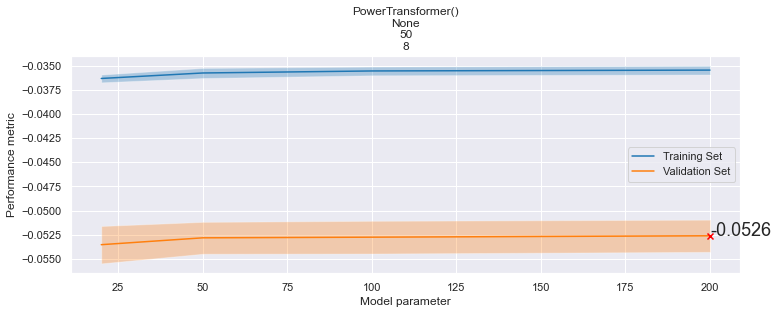

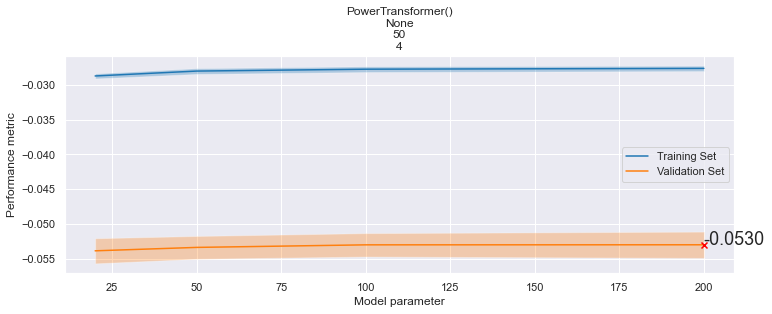

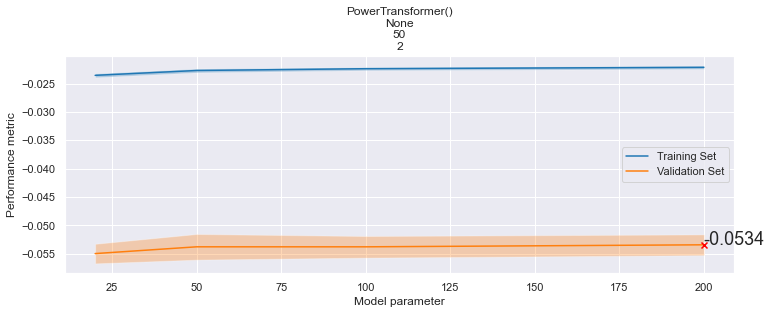

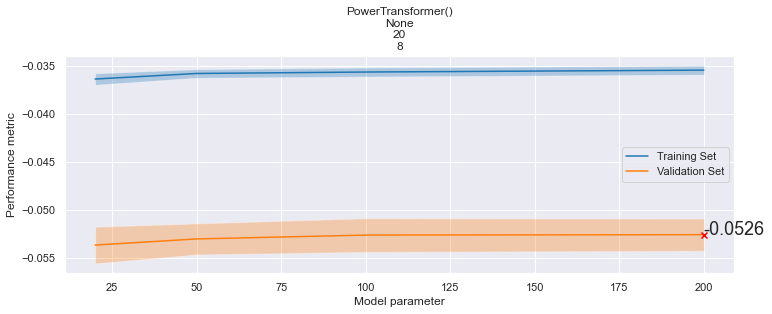

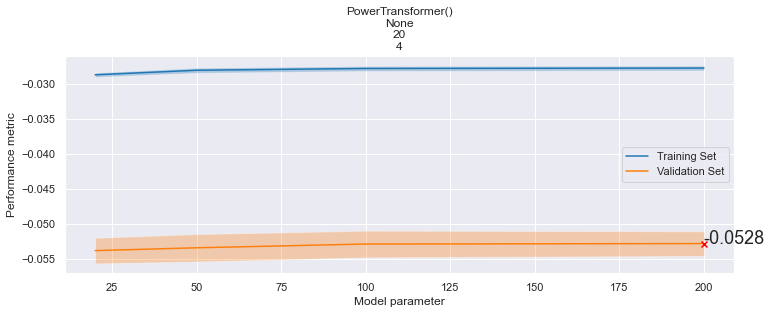

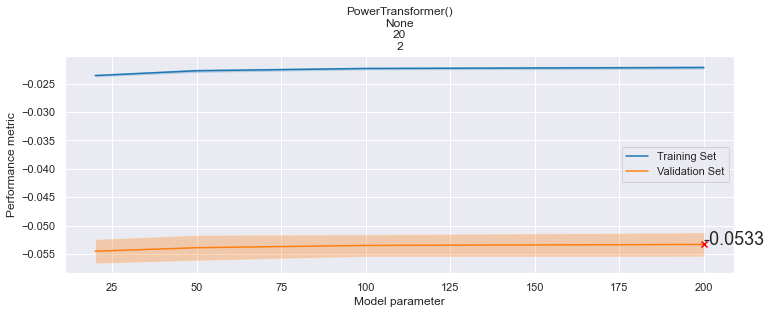

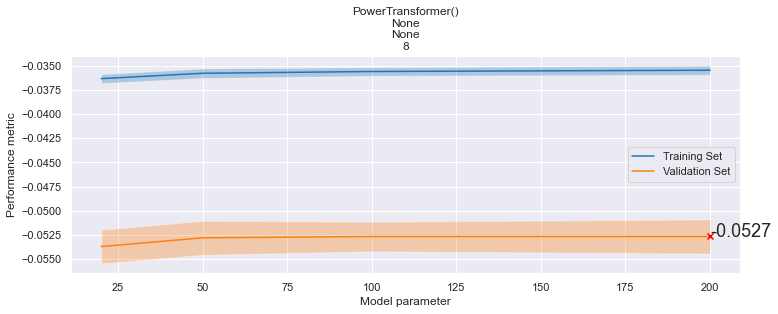

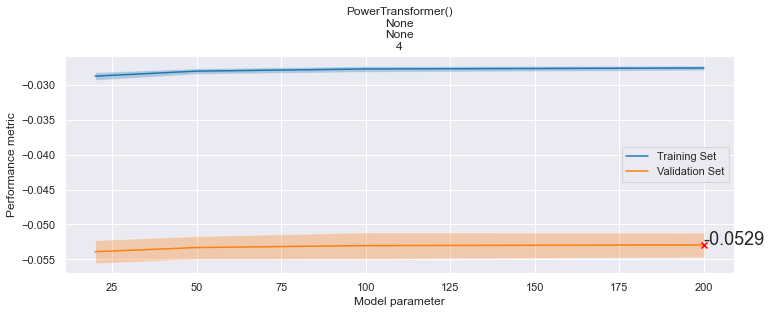

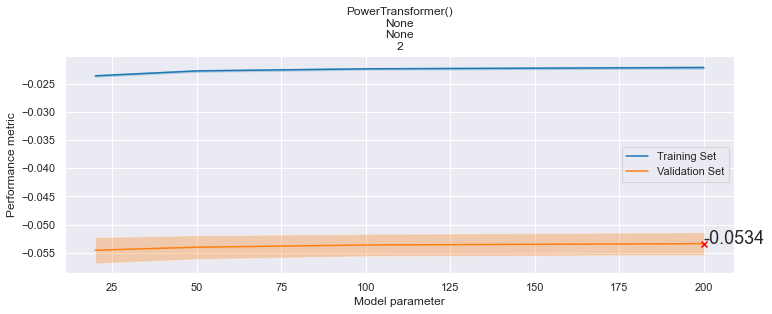

param_estimator__max_depth param_estimator__min_samples_leaf  \
22                         10                                 8   
23                         10                                 8   
70                         50                                 8   
47                         20                                 8   
71                         50                                 8   
94                       None                                 8   
45                         20                                 8   
44                         20                                 8   
20                         10                                 8   
14                         10                                 4   

   param_estimator__n_estimators param_pca        param_scaler  \
22                           200      None      RobustScaler()   
23                           200      None  PowerTransformer()   
70                           200      None      RobustScaler()   
47                           200      None  PowerTransformer()   
71                           200      None  PowerTransformer()   
94                           200      None      RobustScaler()   
45                           100      None  PowerTransformer()   
44                           100      None      RobustScaler()   
20                           100      None      RobustScaler()   
14                           200      None      RobustScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
22        -0.052539        0.001725         -0.036611         0.000445  
23        -0.052581        0.001693         -0.036578         0.000493  
70        -0.052585        0.001672         -0.035515         0.000441  
47        -0.052599        0.001678         -0.035448         0.000463  
71        -0.052600        0.001662         -0.035473         0.000456  
94        -0.052625        0.001773         -0.035508         0.000460  
45        -0.052640        0.001753         -0.035645         0.000469  
44        -0.052641        0.001624         -0.035531         0.000435  
20        -0.052644        0.001746         -0.036665         0.000513  
14        -0.052655        0.001824         -0.031785         0.000540

Starting with target: domain1_var2
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 23.9min finished
/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Best: -0.057304 using {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 8, 'estimator__n_estimators': 200, 'pca': None, 'scaler': PowerTransformer()}


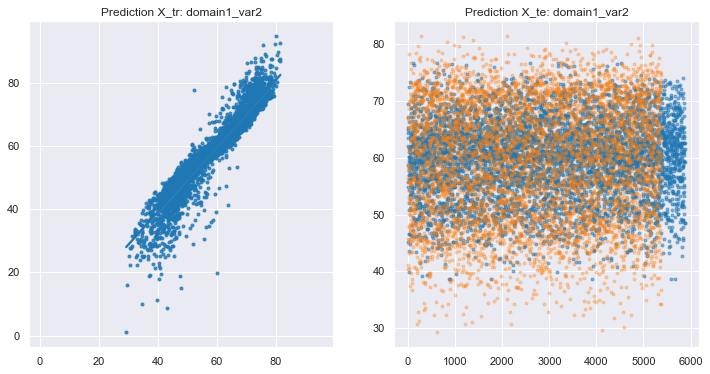

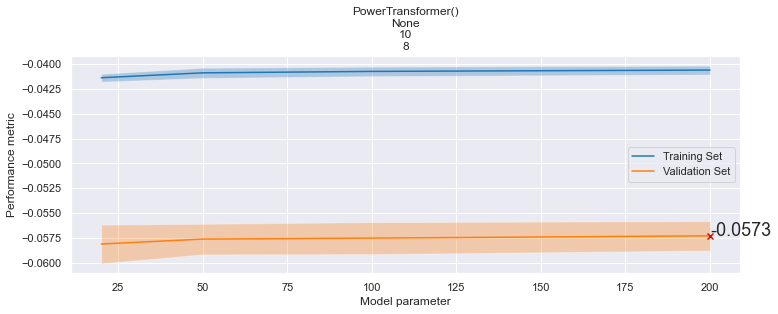

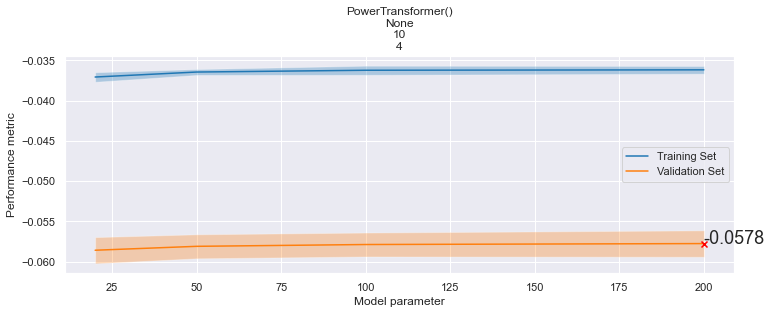

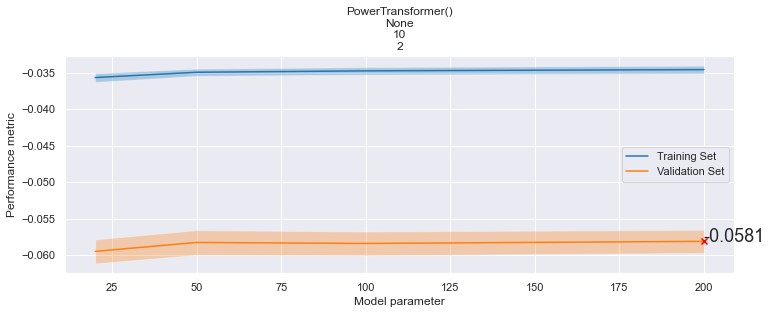

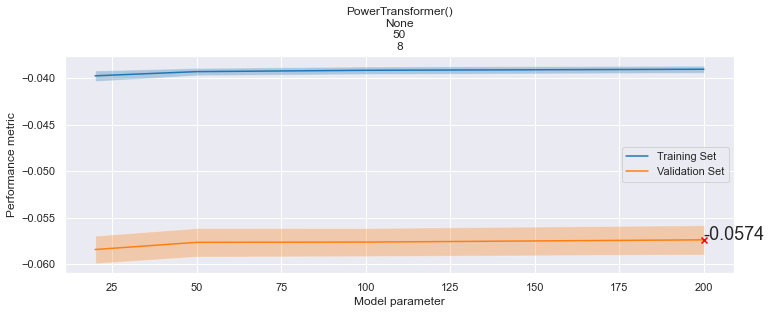

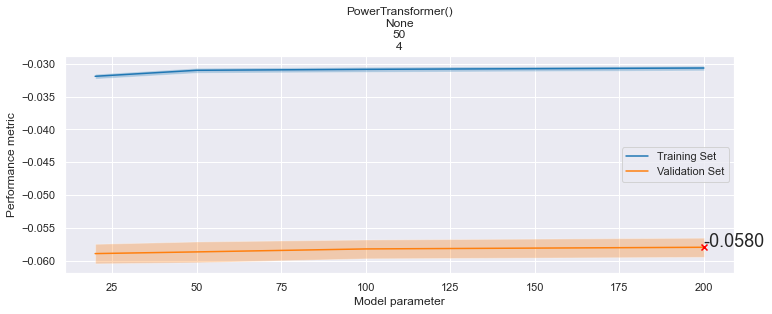

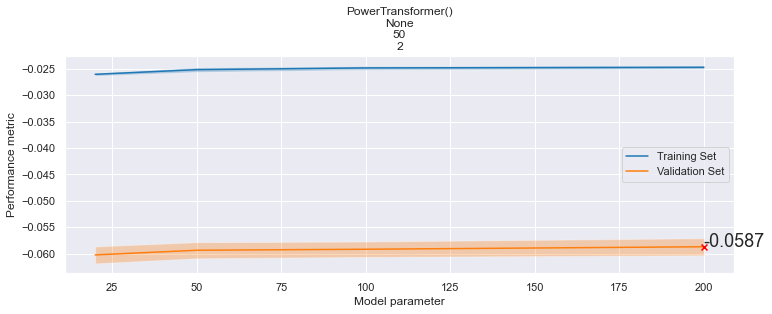

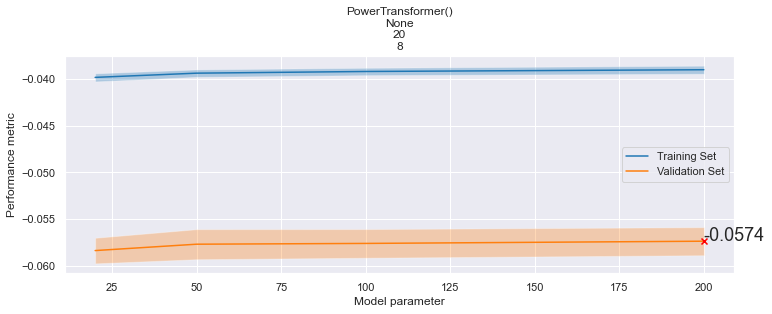

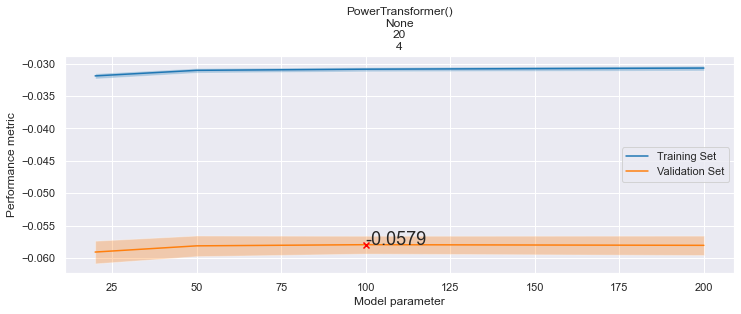

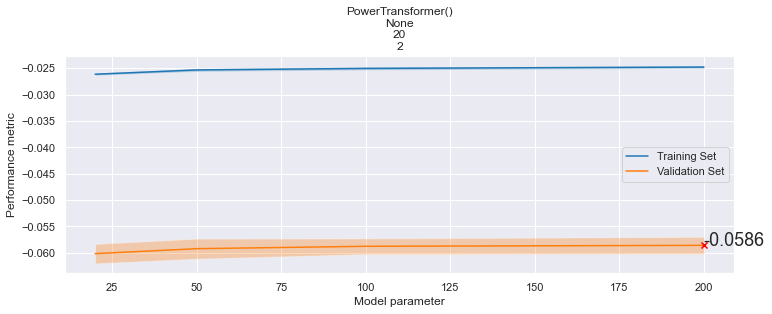

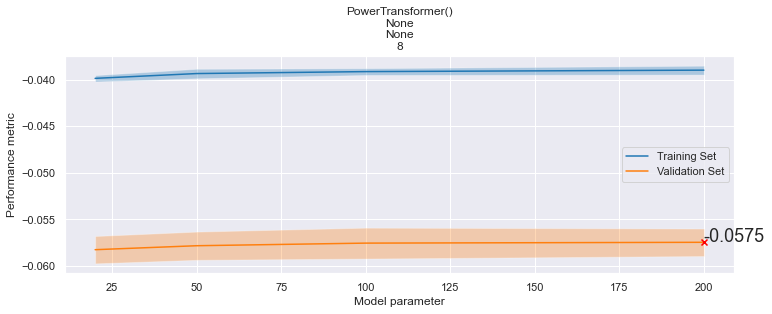

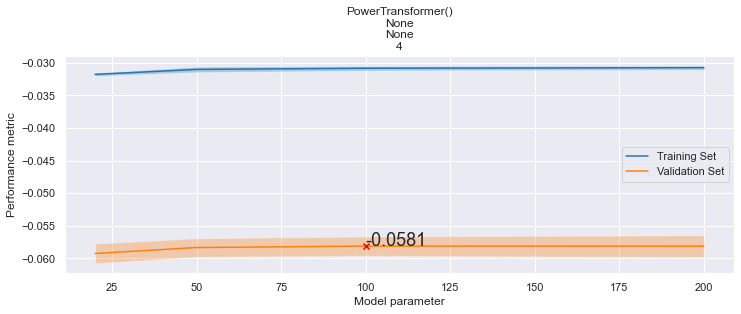

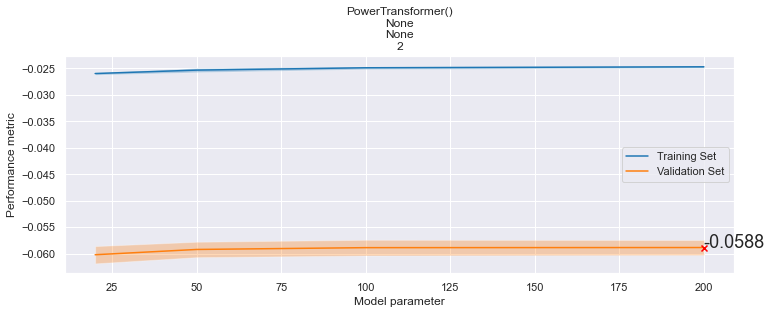

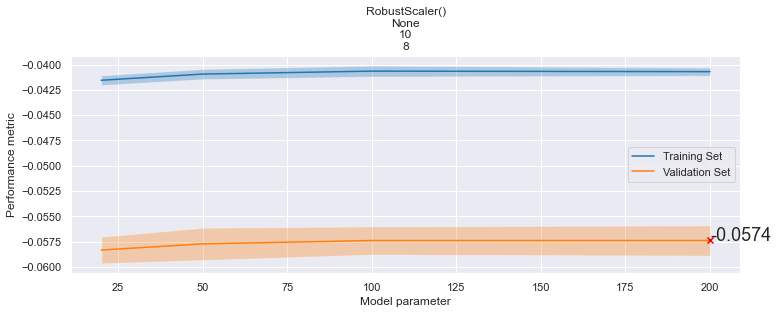

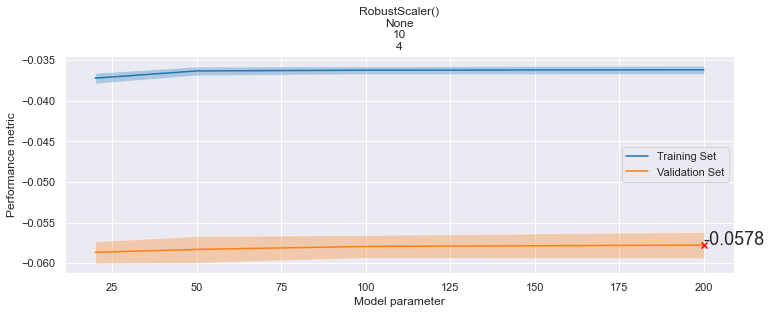

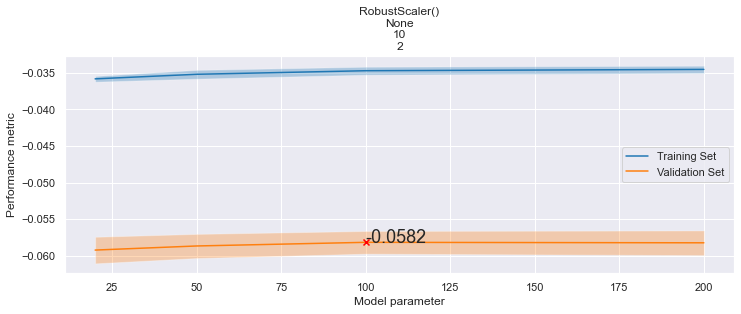

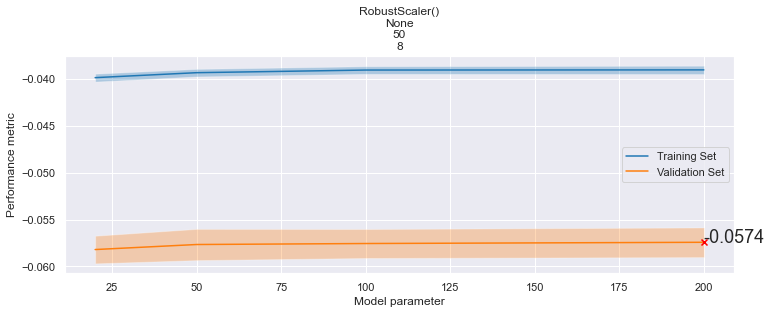

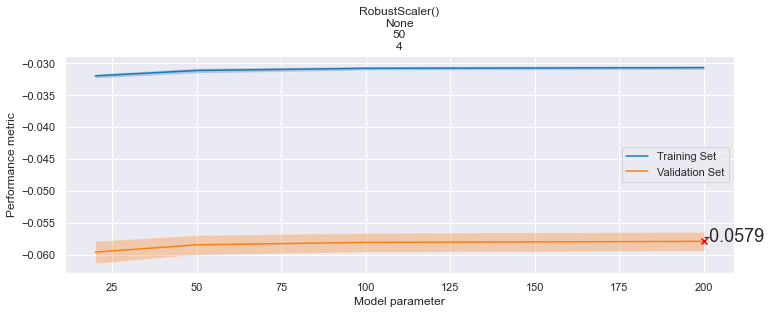

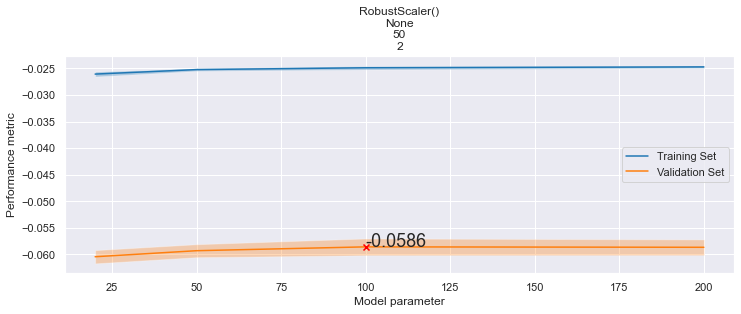

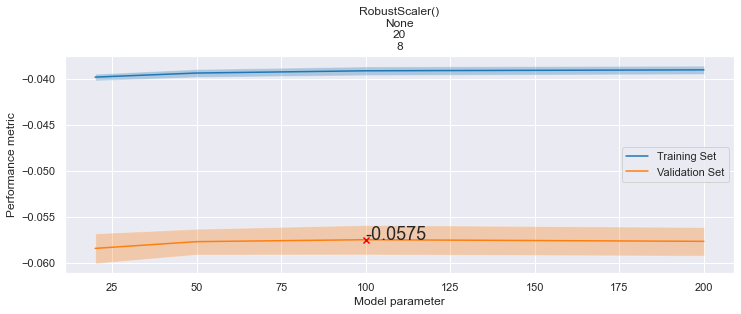

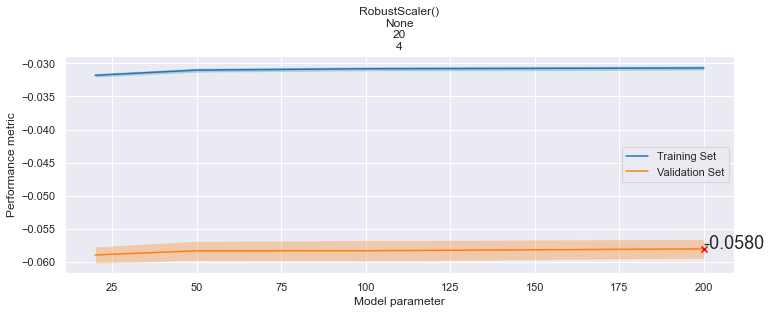

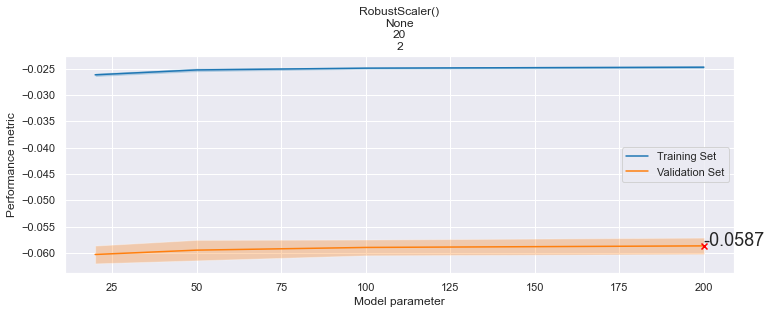

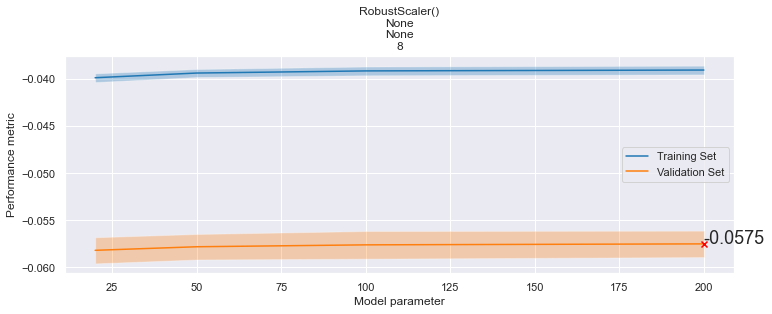

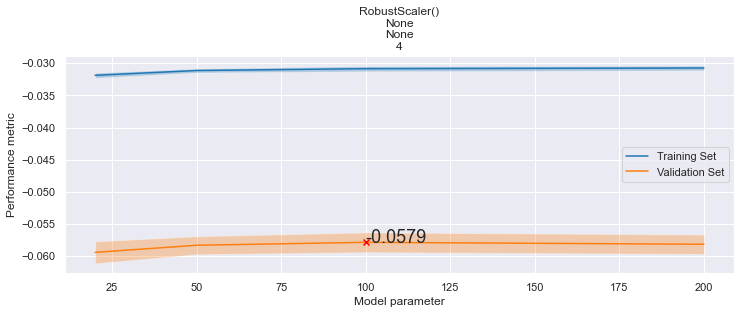

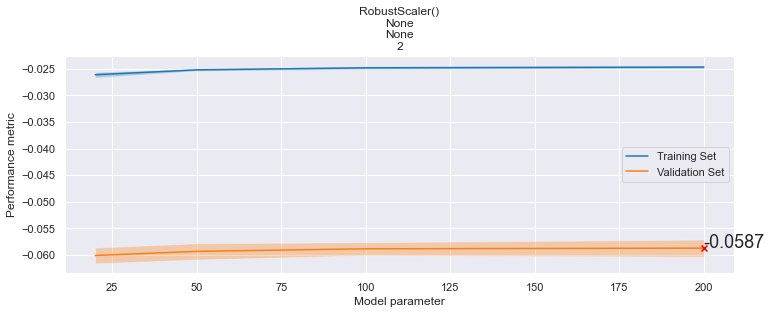

param_estimator__max_depth param_estimator__min_samples_leaf  \
23                         10                                 8   
71                         50                                 8   
47                         20                                 8   
22                         10                                 8   
20                         10                                 8   
70                         50                                 8   
95                       None                                 8   
94                       None                                 8   
44                         20                                 8   
21                         10                                 8   

   param_estimator__n_estimators param_pca        param_scaler  \
23                           200      None  PowerTransformer()   
71                           200      None  PowerTransformer()   
47                           200      None  PowerTransformer()   
22                           200      None      RobustScaler()   
20                           100      None      RobustScaler()   
70                           200      None      RobustScaler()   
95                           200      None  PowerTransformer()   
94                           200      None      RobustScaler()   
44                           100      None      RobustScaler()   
21                           100      None  PowerTransformer()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
23        -0.057304        0.001479         -0.040589         0.000441  
71        -0.057376        0.001579         -0.039036         0.000380  
47        -0.057380        0.001503         -0.038995         0.000432  
22        -0.057397        0.001494         -0.040687         0.000401  
20        -0.057399        0.001390         -0.040634         0.000536  
70        -0.057419        0.001580         -0.039039         0.000446  
95        -0.057453        0.001473         -0.038995         0.000477  
94        -0.057497        0.001401         -0.039037         0.000462  
44        -0.057505        0.001605         -0.039117         0.000470  
21        -0.057533        0.001611         -0.040724         0.000475

Starting with target: domain2_var1
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 23.8min finished
/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Best: -0.068471 using {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 8, 'estimator__n_estimators': 200, 'pca': None, 'scaler': PowerTransformer()}


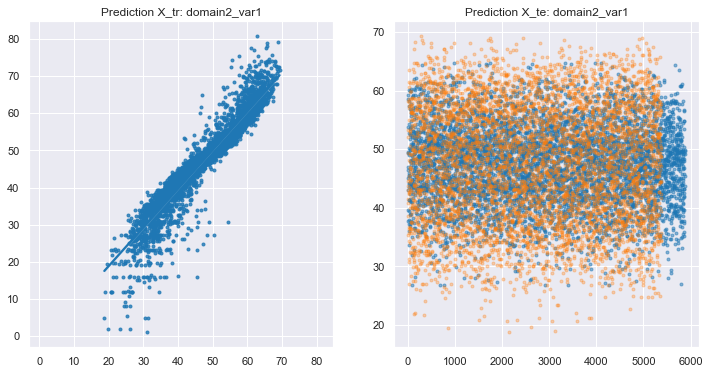

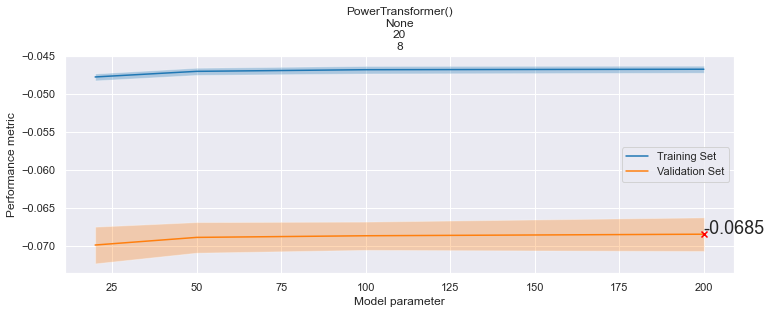

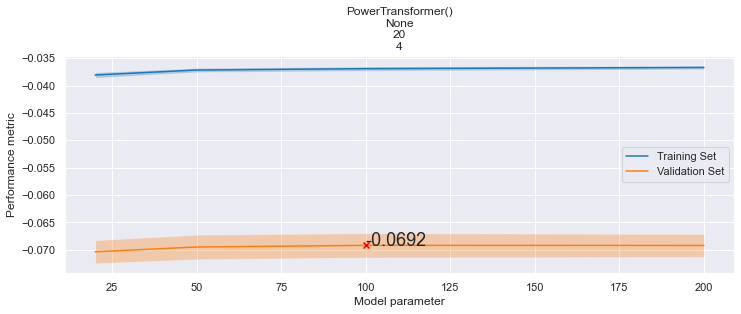

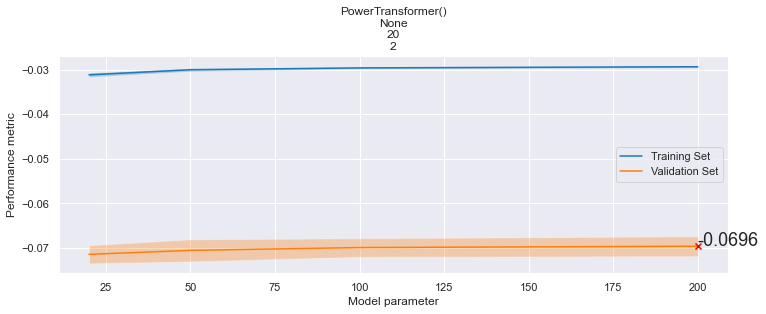

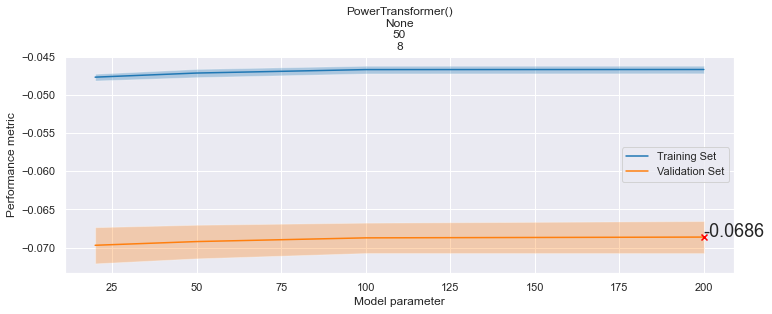

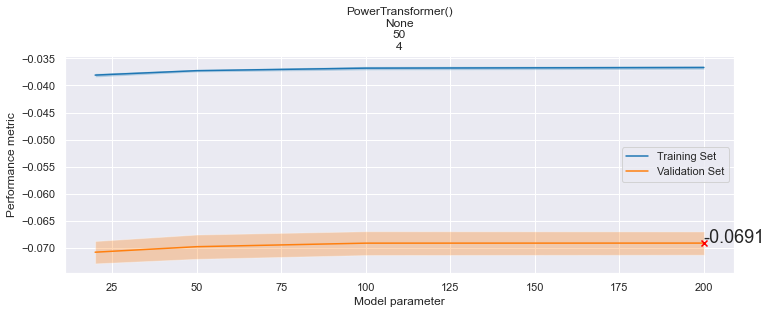

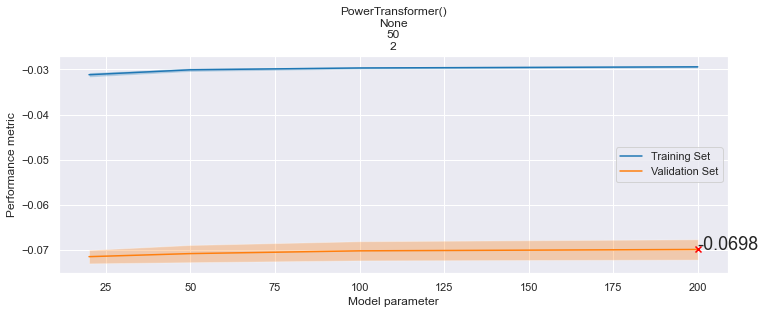

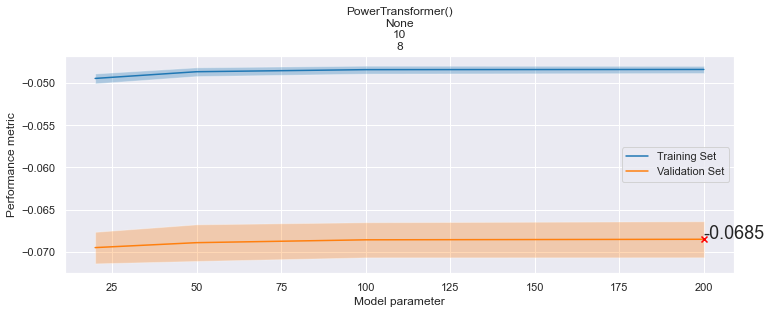

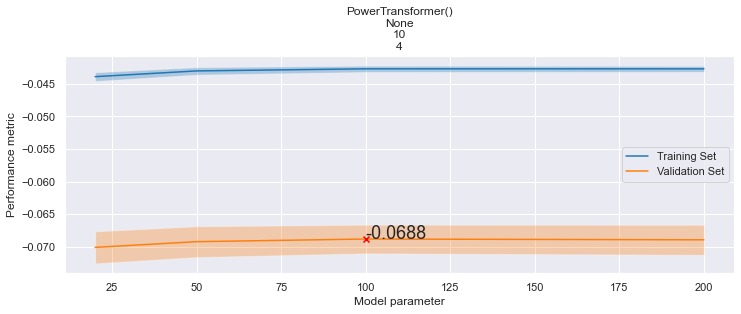

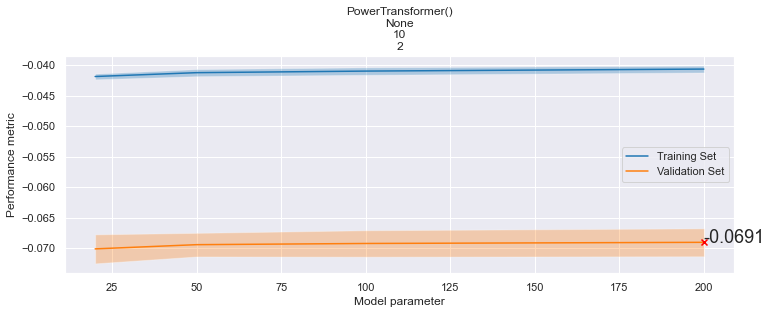

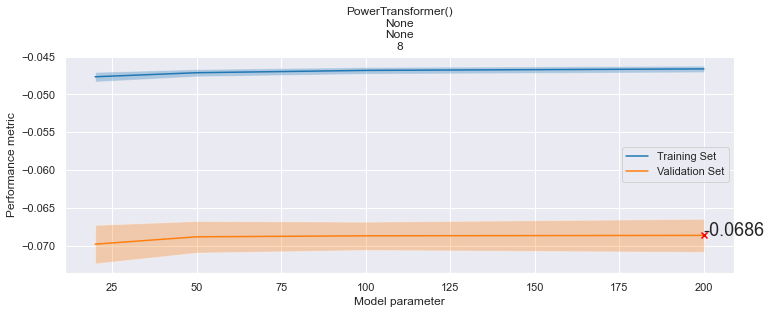

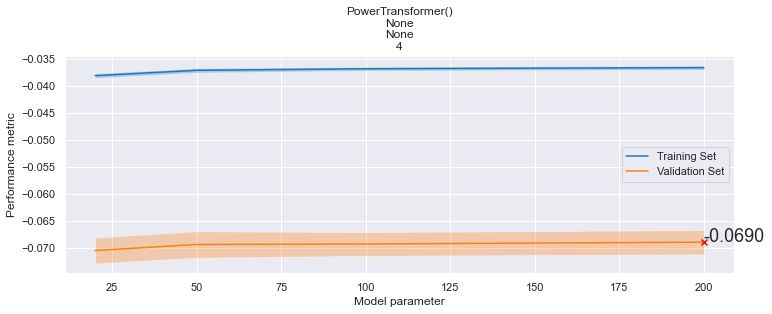

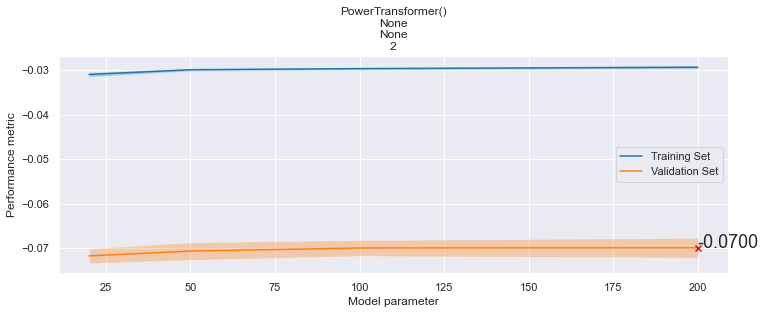

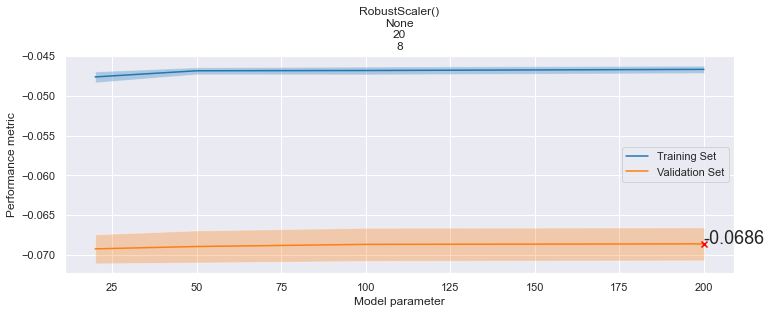

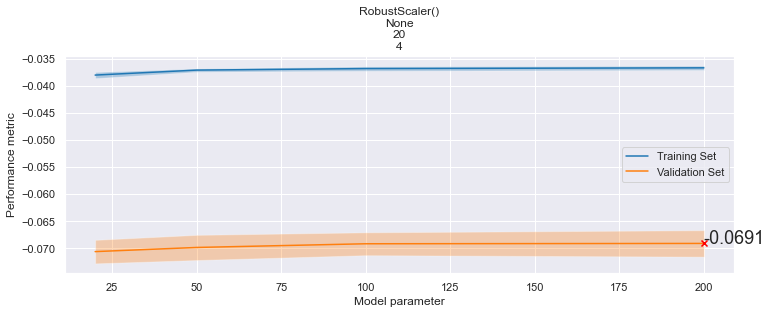

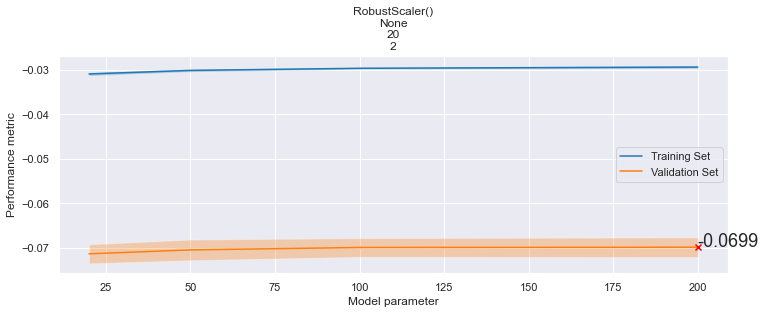

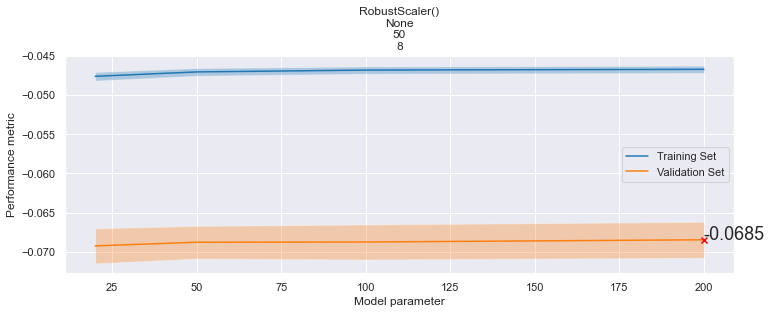

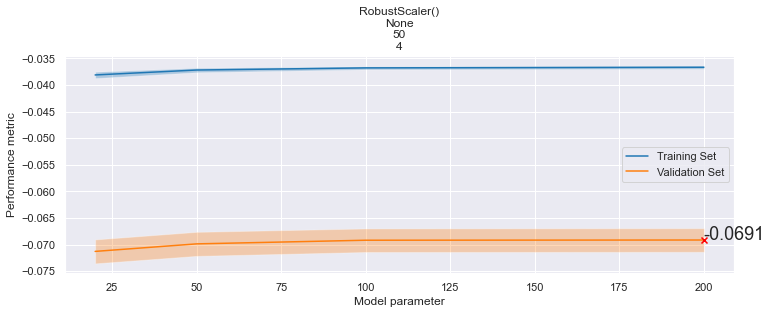

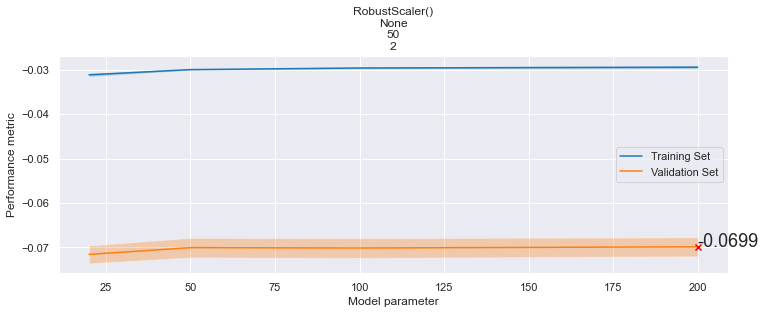

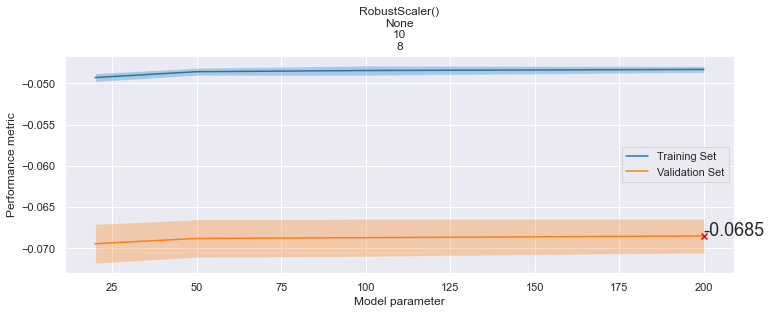

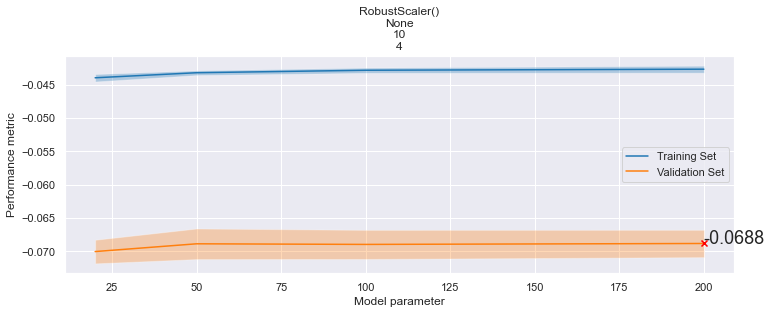

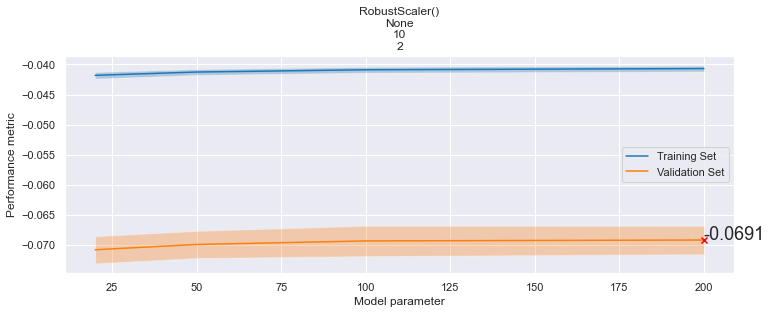

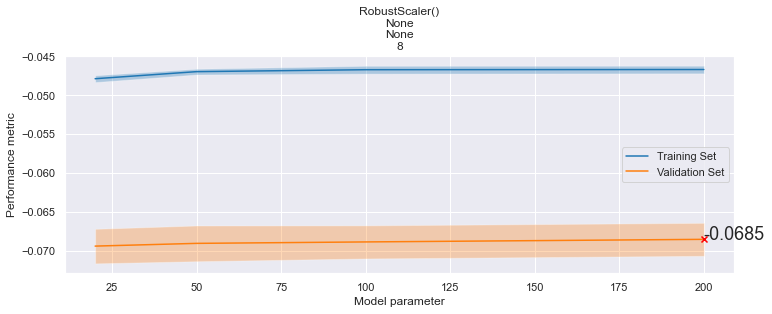

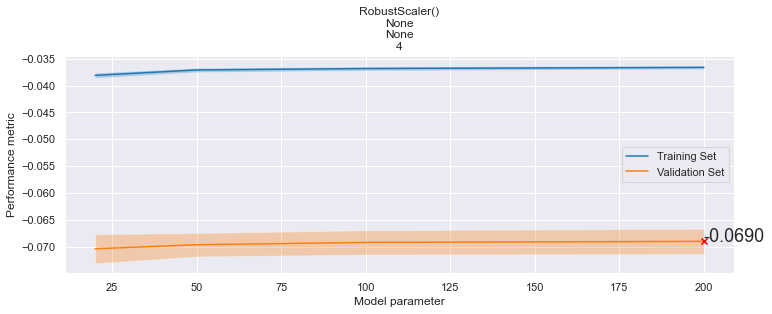

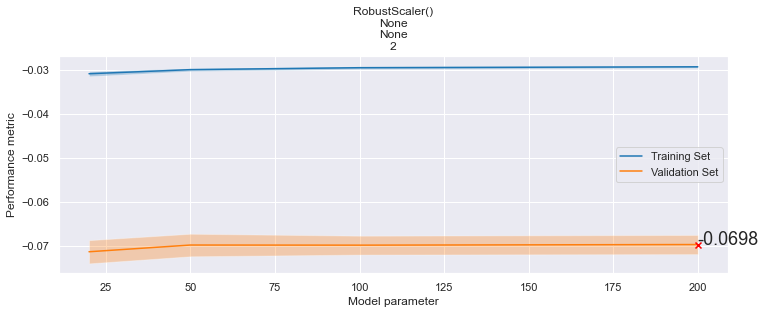

param_estimator__max_depth param_estimator__min_samples_leaf  \
47                         20                                 8   
70                         50                                 8   
22                         10                                 8   
94                       None                                 8   
23                         10                                 8   
21                         10                                 8   
71                         50                                 8   
46                         20                                 8   
95                       None                                 8   
45                         20                                 8   

   param_estimator__n_estimators param_pca        param_scaler  \
47                           200      None  PowerTransformer()   
70                           200      None      RobustScaler()   
22                           200      None      RobustScaler()   
94                           200      None      RobustScaler()   
23                           200      None  PowerTransformer()   
21                           100      None  PowerTransformer()   
71                           200      None  PowerTransformer()   
46                           200      None      RobustScaler()   
95                           200      None  PowerTransformer()   
45                           100      None  PowerTransformer()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
47        -0.068471        0.002219         -0.046707         0.000466  
70        -0.068482        0.002294         -0.046688         0.000462  
22        -0.068491        0.002081         -0.048291         0.000391  
94        -0.068504        0.002118         -0.046693         0.000491  
23        -0.068521        0.002138         -0.048362         0.000426  
21        -0.068584        0.002084         -0.048385         0.000469  
71        -0.068613        0.002097         -0.046686         0.000498  
46        -0.068626        0.002071         -0.046666         0.000461  
95        -0.068632        0.002183         -0.046637         0.000424  
45        -0.068676        0.001864         -0.046769         0.000498

Starting with target: domain2_var2
Size of dataset:  (5378, 102)
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 23.8min finished
/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Best: -0.068008 using {'estimator__max_depth': 50, 'estimator__min_samples_leaf': 8, 'estimator__n_estimators': 200, 'pca': None, 'scaler': PowerTransformer()}


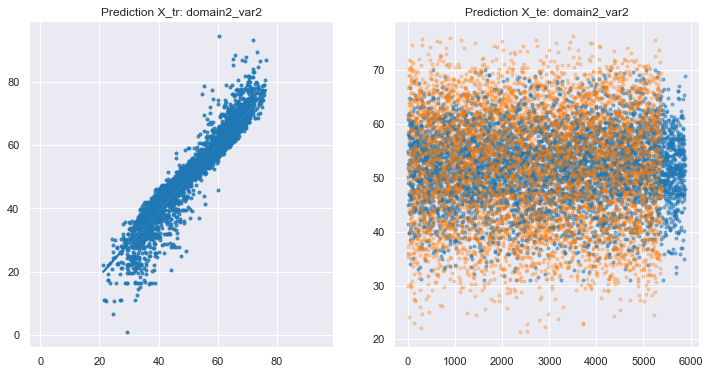

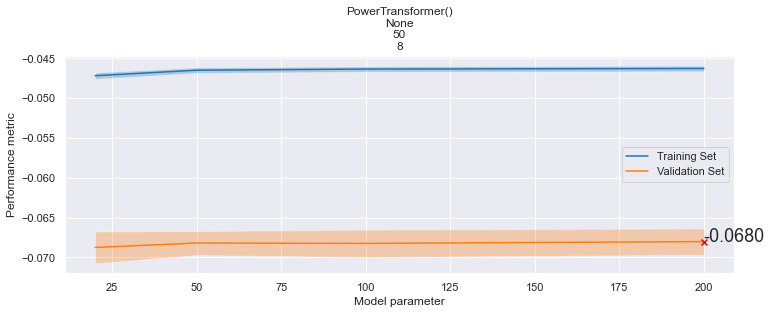

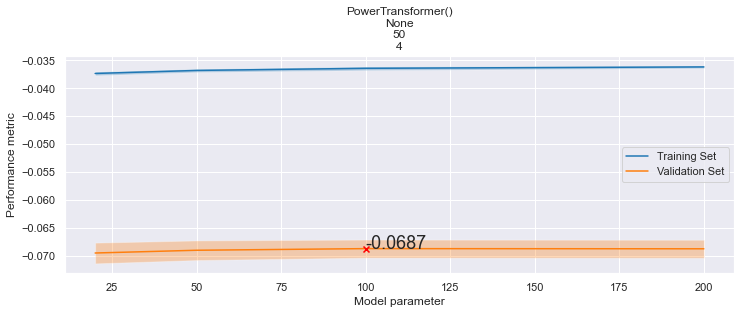

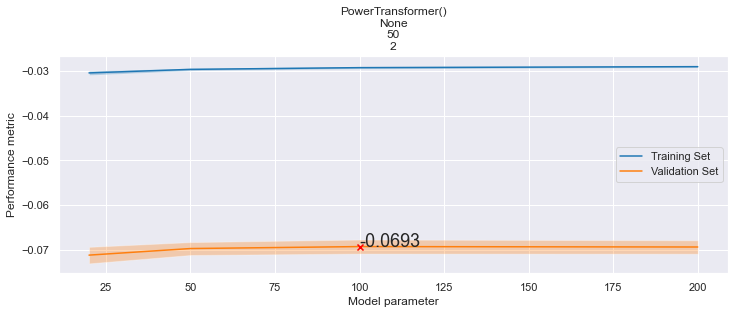

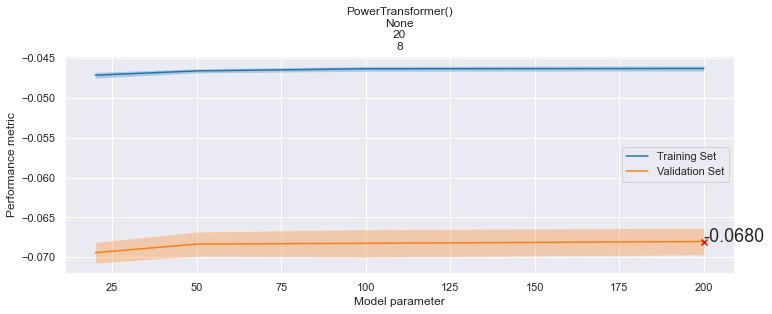

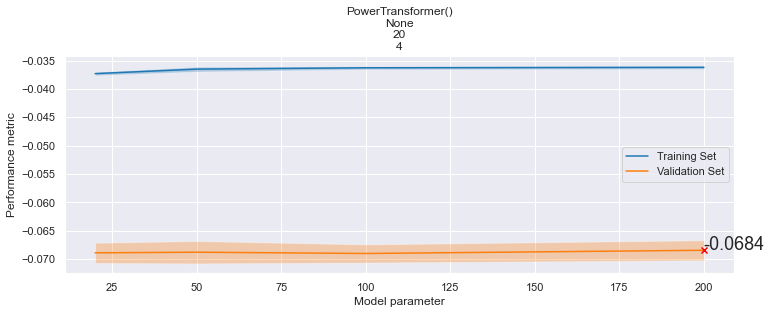

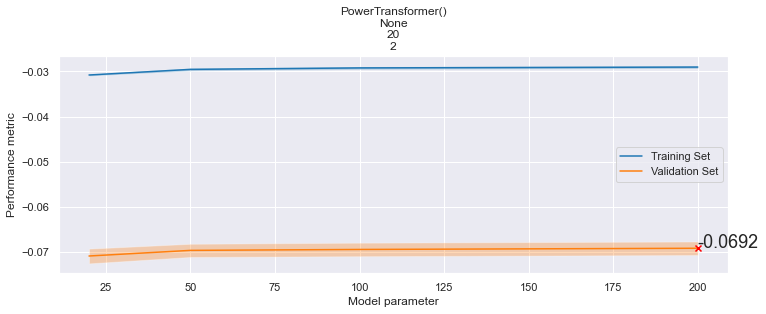

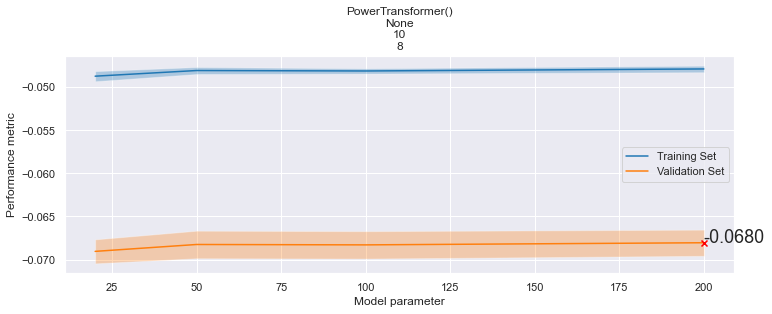

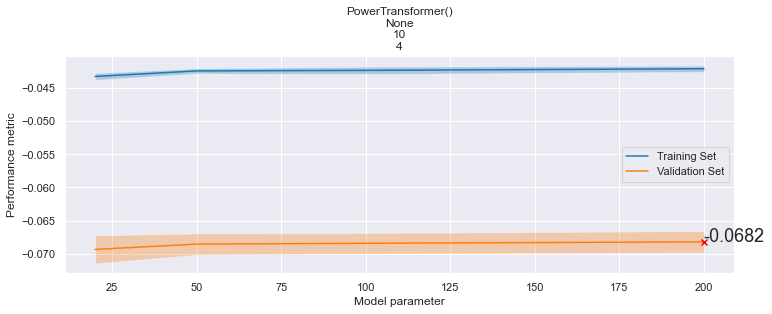

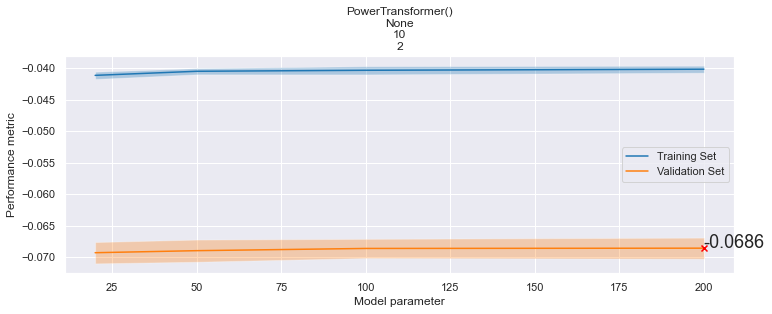

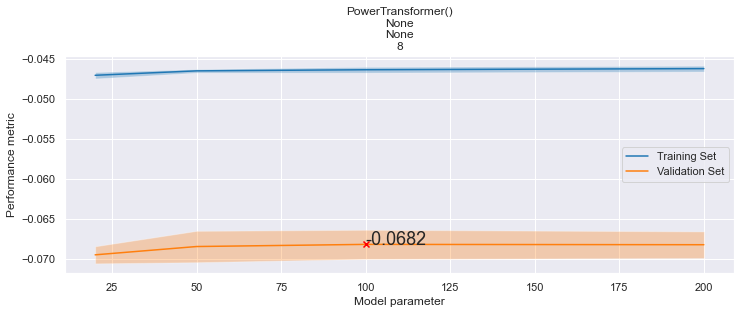

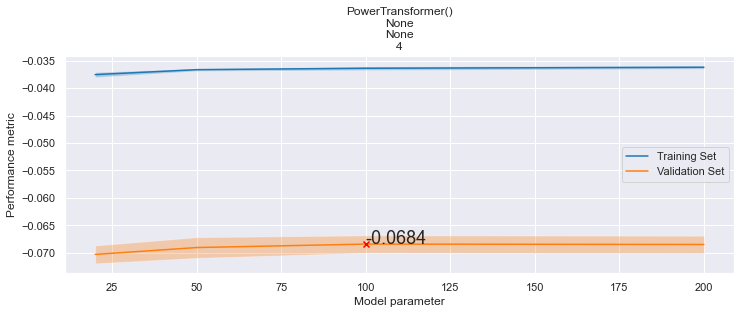

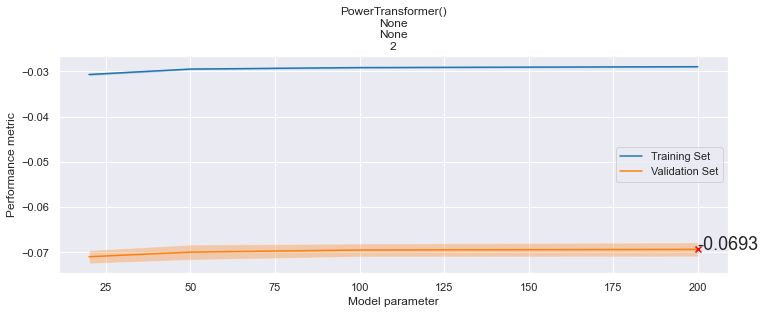

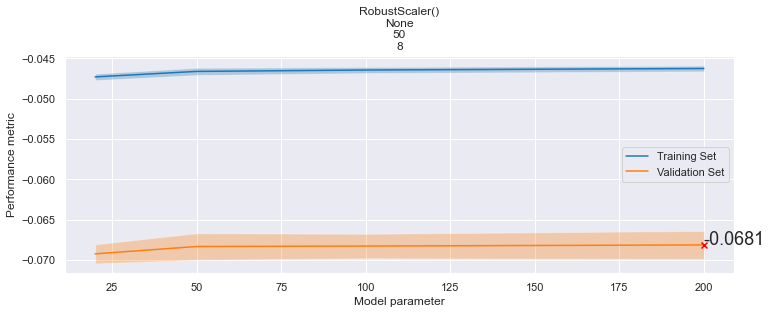

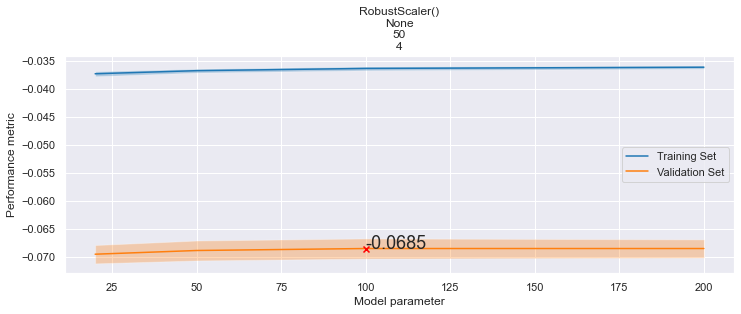

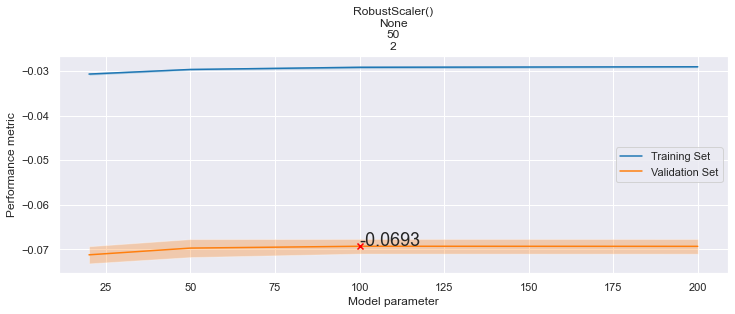

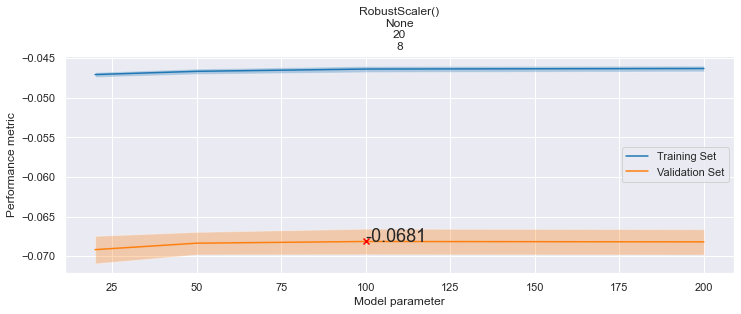

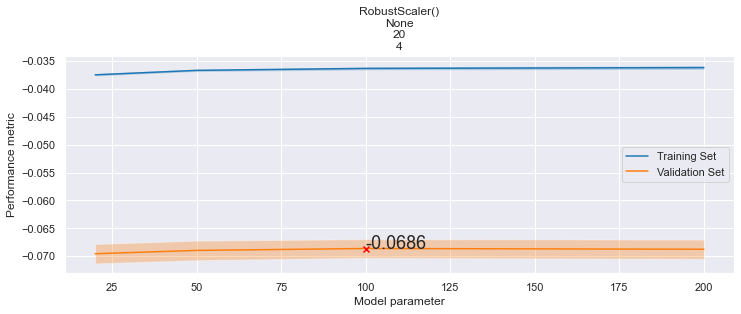

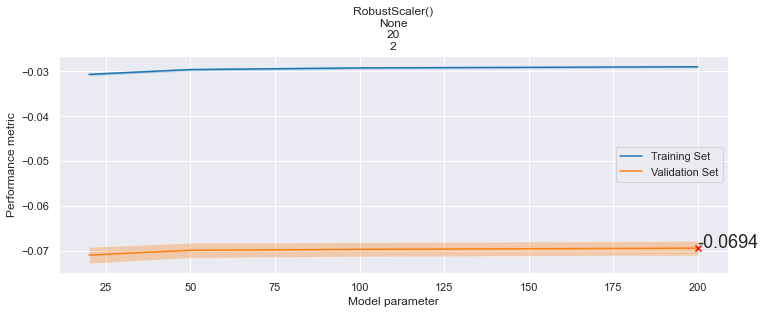

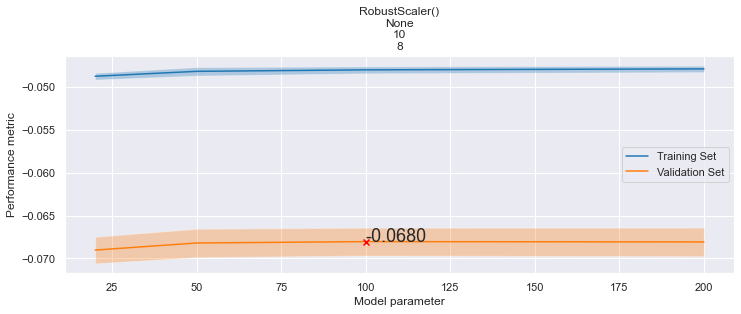

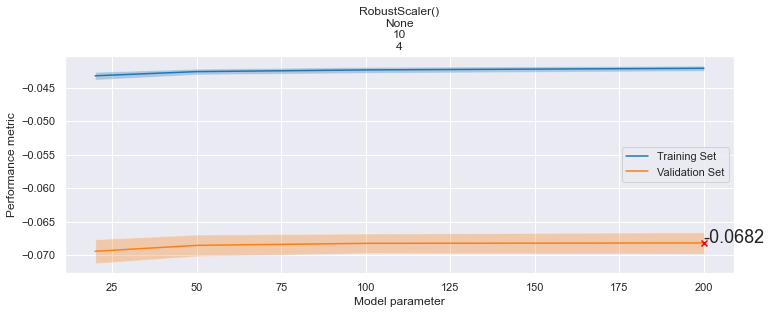

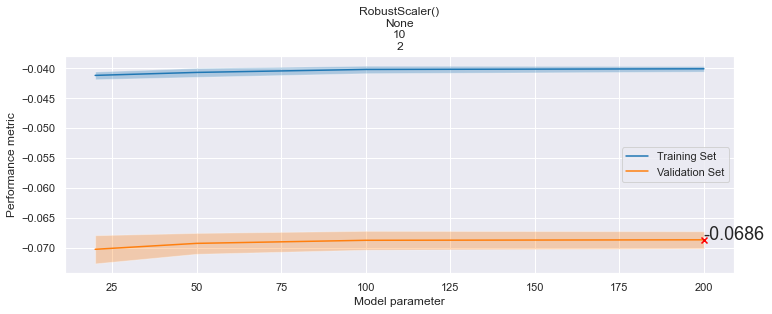

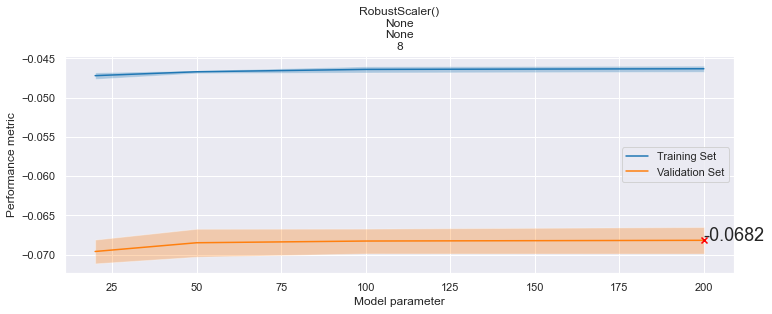

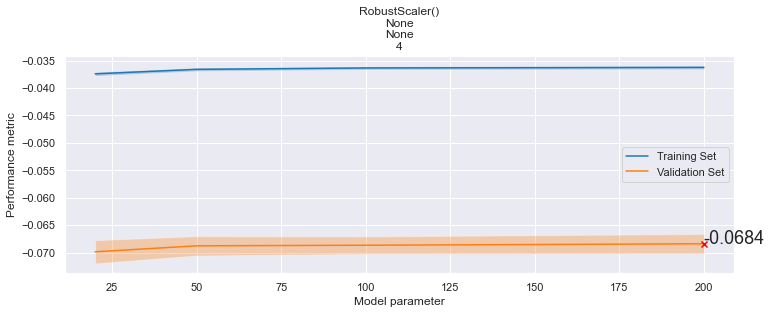

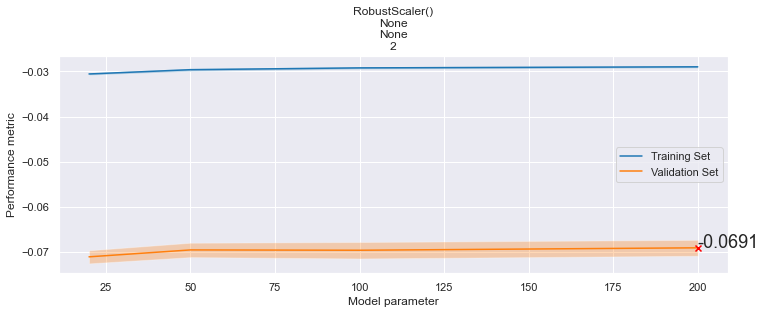

param_estimator__max_depth param_estimator__min_samples_leaf  \
71                         50                                 8   
47                         20                                 8   
20                         10                                 8   
23                         10                                 8   
22                         10                                 8   
70                         50                                 8   
44                         20                                 8   
93                       None                                 8   
14                         10                                 4   
94                       None                                 8   

   param_estimator__n_estimators param_pca        param_scaler  \
71                           200      None  PowerTransformer()   
47                           200      None  PowerTransformer()   
20                           100      None      RobustScaler()   
23                           200      None  PowerTransformer()   
22                           200      None      RobustScaler()   
70                           200      None      RobustScaler()   
44                           100      None      RobustScaler()   
93                           100      None  PowerTransformer()   
14                           200      None      RobustScaler()   
94                           200      None      RobustScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
71        -0.068008        0.001652         -0.046274         0.000350  
47        -0.068020        0.001713         -0.046291         0.000347  
20        -0.068038        0.001621         -0.048014         0.000402  
23        -0.068048        0.001517         -0.047874         0.000378  
22        -0.068076        0.001667         -0.047903         0.000373  
70        -0.068143        0.001740         -0.046252         0.000347  
44        -0.068144        0.001614         -0.046365         0.000383  
93        -0.068152        0.001817         -0.046398         0.000357  
14        -0.068169        0.001599         -0.042093         0.000387  
94        -0.068176        0.001691         -0.046308         0.000390

score  estimator__max_depth  estimator__min_samples_leaf  \
0  0.035672                    20                            4   
1  0.052539                    10                            8   
2  0.057304                    10                            8   
3  0.068471                    20                            8   
4  0.068008                    50                            8   

   estimator__n_estimators   pca              scaler  
0                      200  None      RobustScaler()  
1                      200  None      RobustScaler()  
2                      200  None  PowerTransformer()  
3                      200  None  PowerTransformer()  
4                      200  None  PowerTransformer()

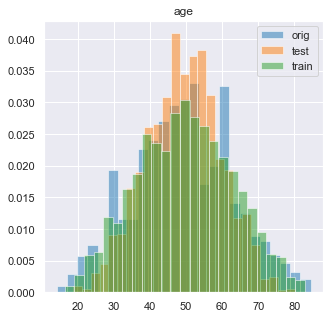

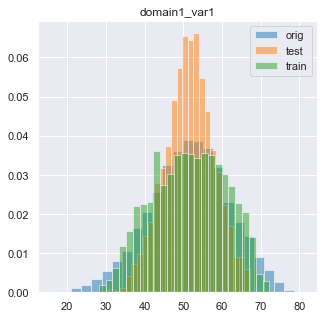

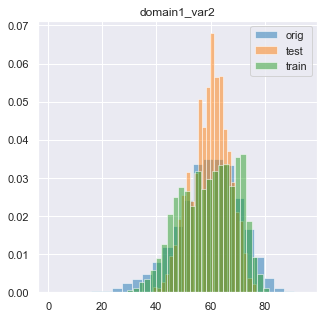

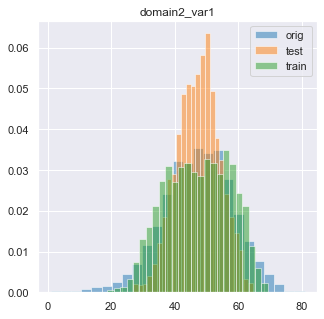

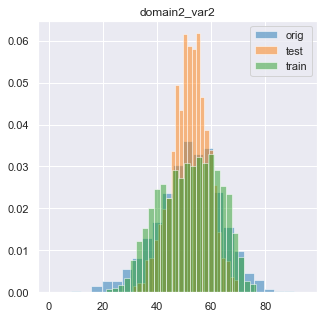

Score: 0.0538 | -0.0357 -0.0525 -0.0573 -0.0685 -0.0680


In [25]:
dataset_id = 'rf'

predictions = {}
scores = []
grids = []

for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

    print('Starting with target: %s' % (target))
    estimator = RandomForestRegressor()
    df_pred, pred_tr, pred_te, grid, idx = run_prediction(
        model_metric, target=target, estimator=estimator, tidx=tidx)

    display_grid_optimization_details(grid)

    predictions['%s_tr' % target] = pred_tr
    predictions['%s_te' % target] = pred_te
    predictions['%s_miss' % target] = idx

    scores.append(grid.best_score_)
    grids.append(grid)

# Display grids summary
grids_summary(grids)

# Compute overall score
weights = [.3, .175, .175, .175, .175]
score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

df_results_tr, df_results_te = save_results(
    predictions, targets, train_id, test_id, sample_submission, dataset_id, score_postfix)

_, _, y_tr, _ = load_dataset()
df_target = pd.DataFrame(y_tr, columns=targets.columns)
plot_prediction_distributions(df_target, df_results_tr, df_results_te)

# Feedback of overall score
txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
print(txt)